# ICE Building Workflow - Knowledge Graph Construction

**Purpose**: Comprehensive data ingestion and knowledge graph building for investment intelligence
**Architecture**: ICE Simplified (2,508 lines) with LightRAG integration
**Input**: Financial data from multiple sources → **Output**: Searchable knowledge graph

## Workflow Overview

1. **Environment Setup** - Initialize ICE system and configure data sources
2. **Workflow Mode Selection** - Choose between initial build or incremental update
3. **Data Ingestion** - Fetch financial data from APIs and process documents
4. **Knowledge Graph Building** - Extract entities, relationships, and build LightRAG graph
5. **Storage & Validation** - Verify graph construction and monitor storage
6. **Metrics & Monitoring** - Track processing metrics and system health

---

## 1. Environment Setup & System Initialization

In [1]:
# Setup and imports
import sys
import os
from pathlib import Path
from datetime import datetime, timedelta
import json

# Add project root to path
project_root = Path.cwd()
sys.path.insert(0, str(project_root))

# Configure environment
os.environ.setdefault('ICE_WORKING_DIR', './src/ice_lightrag/storage')

print(f"🚀 ICE Building Workflow")
print(f"📅 {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print(f"📁 Working Directory: {project_root}")

🚀 ICE Building Workflow
📅 2025-10-29 15:44
📁 Working Directory: /Users/royyeo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Capstone Project


In [2]:
# Initialize ICE system
from updated_architectures.implementation.ice_simplified import create_ice_system

try:
    ice = create_ice_system()
    system_ready = ice.is_ready()
    print(f"✅ ICE System Initialized")
    print(f"🧠 LightRAG Status: {'Ready' if system_ready else 'Initializing'}")
    print(f"📊 Architecture: ICE Simplified (2,508 lines)")
    print(f"🔗 Components: Core + Ingester + QueryEngine")
except Exception as e:
    print(f"❌ Initialization Error: {e}")
    raise  # Let errors surface for proper debugging

INFO:ice_data_ingestion.ice_integration:ICE LightRAG system initialized successfully
INFO:ice_data_ingestion.ice_integration:ICE LightRAG system initialized successfully


✅ LightRAG successfully imported!


INFO:updated_architectures.implementation.ice_simplified:ICE Core initializing with ICESystemManager orchestration
INFO:src.ice_core.ice_system_manager:ICE System Manager initialized with working_dir: ice_lightrag/storage
INFO:updated_architectures.implementation.ice_simplified:✅ ICESystemManager initialized successfully
INFO:imap_email_ingestion_pipeline.entity_extractor:spaCy model loaded successfully
INFO:src.ice_docling.docling_processor:DoclingProcessor initialized: storage=/Users/royyeo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Capstone Project/data/attachments
INFO:updated_architectures.implementation.data_ingestion:✅ DoclingProcessor initialized (97.9% table accuracy)
INFO:updated_architectures.implementation.data_ingestion:✅ BenzingaClient initialized (real-time professional news)
INFO:imap_email_ingestion_pipeline.intelligent_link_processor.IntelligentLinkProcessor:Intelligent Link Processor initialized. Download dir: /Users/royyeo/Library/CloudStorage/OneDr

✅ ICE System Initialized
🧠 LightRAG Status: Ready
📊 Architecture: ICE Simplified (2,508 lines)
🔗 Components: Core + Ingester + QueryEngine


In [3]:
# Verify storage architecture and components
print(f"📦 LightRAG Storage Architecture Verification")
print(f"━" * 40)

if not (ice and ice.core.is_ready()):
    raise RuntimeError("ICE system not ready - cannot verify storage")

# Get storage statistics using new method
storage_stats = ice.core.get_storage_stats()

print(f"LightRAG Storage Components:")
for component_name, component_info in storage_stats['components'].items():
    status = "✅ Initialized" if component_info['exists'] else "⚠️ Not created yet"
    size_mb = component_info['size_bytes'] / (1024 * 1024) if component_info['size_bytes'] > 0 else 0
    print(f"  {component_name}: {status}")
    print(f"    Purpose: {component_info['description']}")
    print(f"    File: {component_info['file']}")
    if size_mb > 0:
        print(f"    Size: {size_mb:.2f} MB")

print(f"\n📁 Working Directory: {storage_stats['working_dir']}")
print(f"🗄️ Storage Backend: File-based (development mode)")
print(f"💾 Total Storage: {storage_stats['total_storage_bytes'] / (1024 * 1024):.2f} MB")

📦 LightRAG Storage Architecture Verification
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
LightRAG Storage Components:
  chunks_vdb: ⚠️ Not created yet
    Purpose: Vector database for document chunks
    File: vdb_chunks.json
  entities_vdb: ⚠️ Not created yet
    Purpose: Vector database for extracted entities
    File: vdb_entities.json
  relationships_vdb: ⚠️ Not created yet
    Purpose: Vector database for entity relationships
    File: vdb_relationships.json
  graph: ⚠️ Not created yet
    Purpose: NetworkX graph structure
    File: graph_chunk_entity_relation.graphml

📁 Working Directory: ice_lightrag/storage
🗄️ Storage Backend: File-based (development mode)
💾 Total Storage: 0.00 MB


In [4]:
# Data sources configuration status
if not (ice and hasattr(ice, 'ingester')):
    raise RuntimeError("Data ingester not initialized")

available_services = ice.ingester.available_services
print(f"\n📡 Data Sources Available: {len(available_services)}")
for service in available_services:
    print(f"  ✅ {service}")

if not available_services:
    print(f"  ⚠️ No APIs configured - will use sample data")
    print(f"  💡 Set NEWSAPI_ORG_API_KEY for real news")
    print(f"  💡 Set ALPHA_VANTAGE_API_KEY for financial data")

# Validate OpenAI for LightRAG
openai_configured = bool(os.getenv('OPENAI_API_KEY'))
print(f"\n🔑 OpenAI API: {'✅ Configured' if openai_configured else '❌ Required for full functionality'}")


📡 Data Sources Available: 7
  ✅ newsapi
  ✅ alpha_vantage
  ✅ fmp
  ✅ polygon
  ✅ finnhub
  ✅ benzinga
  ✅ marketaux

🔑 OpenAI API: ✅ Configured


## 2. Workflow Mode Selection & Configuration

### 🔧 Model Provider Configuration

ICE supports **OpenAI** (paid) or **Ollama** (free local) for LLM and embeddings:

#### Option 1: OpenAI (Default - No setup required)
```bash
export OPENAI_API_KEY="sk-..."
```
- **Cost**: ~$5/month for typical usage
- **Quality**: Highest accuracy for entity extraction and reasoning
- **Setup**: Just set API key

#### Option 2: Ollama (Free Local - Requires setup)
```bash
# Set provider
export LLM_PROVIDER="ollama"

# One-time setup:
ollama serve                      # Start Ollama service
ollama pull qwen3:30b-32k        # Pull LLM model (32k context required)
ollama pull nomic-embed-text      # Pull embedding model
```
- **Cost**: $0/month (completely free)
- **Quality**: Good for most investment analysis tasks
- **Setup**: Requires local Ollama installation and model download

#### Option 3: Hybrid (Recommended for cost-conscious users)
```bash
export LLM_PROVIDER="ollama"           # Use Ollama for LLM
export EMBEDDING_PROVIDER="openai"     # Use OpenAI for embeddings
export OPENAI_API_KEY="sk-..."
```
- **Cost**: ~$2/month (embeddings only)
- **Quality**: Balanced - free LLM with high-quality embeddings

**Current configuration will be logged when you run the next cell.**

### 📄 Docling Document Processing (Switchable Architecture)

ICE supports **switchable document processing** for SEC filings and email attachments:

#### Docling Integration (Default - Professional-grade table extraction)
```bash
export USE_DOCLING_SEC=true          # SEC filings: 0% → 97.9% table extraction
export USE_DOCLING_EMAIL=true        # Email attachments: 42% → 97.9% accuracy
```
- **Accuracy**: 97.9% table extraction (vs 42% with PyPDF2)
- **Cost**: $0/month (local execution)
- **Setup**: Models auto-download on first use (~500MB, one-time)

#### Original Implementations (For comparison testing)
```bash
export USE_DOCLING_SEC=false         # Use metadata-only SEC extraction
export USE_DOCLING_EMAIL=false       # Use PyPDF2/openpyxl processors
```
- **Purpose**: A/B testing and backward compatibility
- **Use when**: Comparing extraction accuracy or troubleshooting

**Note**: Docling uses IBM's AI models (DocLayNet, TableFormer, Granite-Docling VLM) for professional-grade document parsing. Both implementations coexist - toggle switches instantly without code changes.

**More info**: See `md_files/DOCLING_INTEGRATION_TESTING.md` for detailed testing procedures.

### 🌐 Crawl4AI URL Fetching (Switchable Architecture)

ICE supports **hybrid URL fetching** for email links with intelligent routing:

#### Smart Routing Strategy (Default - Simple HTTP only)
```bash
export USE_CRAWL4AI_LINKS=false      # Simple HTTP only (fast, free, default)
```
- **Approach**: Use simple HTTP (aiohttp) for all URLs
- **Works for**: DBS research URLs with embedded tokens, direct PDFs, SEC EDGAR
- **Cost**: $0/month (no browser automation)
- **Speed**: <2 seconds per URL average

#### Crawl4AI Hybrid Routing (Enable for complex sites)
```bash
export USE_CRAWL4AI_LINKS=true       # Enable browser automation for complex URLs
export CRAWL4AI_TIMEOUT=60           # Timeout in seconds (default: 60)
export CRAWL4AI_HEADLESS=true        # Headless mode (default: true)
```
- **Routing**: Automatically classifies URLs and uses appropriate method
  - Simple HTTP: DBS URLs, direct file downloads, SEC EDGAR, static content
  - Crawl4AI: Premium research portals (Goldman, Morgan Stanley), JS-heavy IR sites
- **Fallback**: Graceful degradation to simple HTTP if Crawl4AI fails
- **Cost**: CPU cost for browser automation, free tier usage
- **Use when**: Accessing JavaScript-heavy sites or login-required portals

**Note**: DBS research portal URLs work with simple HTTP (embedded auth tokens in `?E=...` parameter) - no browser automation needed.

**More info**: See `md_files/CRAWL4AI_INTEGRATION_PLAN.md` for detailed integration strategy and `CLAUDE.md` Pattern #6 for code examples.


In [5]:
# ### Provider Switching - Uncomment ONE option below, then restart kernel

#############################################################################
#                              Model Selection                              #
#############################################################################

### Option 1: OpenAI ($5/mo, highest quality)
import os; os.environ['LLM_PROVIDER'] = 'openai'
print("✅ Switched to OpenAI")

# ###Option 2: Hybrid ($2/mo, 60% savings, recommended)
# import os; os.environ['LLM_PROVIDER'] = 'ollama'; os.environ['EMBEDDING_PROVIDER'] = 'openai'
# print("✅ Switched to Hybrid")

# ### Option 3: Full Ollama ($0/mo, faster model)
# import os; os.environ['LLM_PROVIDER'] = 'ollama'; os.environ['EMBEDDING_PROVIDER'] = 'ollama'; 
# # os.environ['LLM_MODEL'] = 'llama3.1:8b'
# os.environ['LLM_MODEL'] = 'qwen3:8b'
# # os.environ['LLM_MODEL'] = 'qwen3:14b'
# # os.environ['LLM_MODEL'] = 'qwen3:30b-32k'
# print("✅ Switched to Full Ollama Model.")

✅ Switched to OpenAI


### 🗑️ Graph Management (Optional)

**When to clear the graph:**
- ✅ Switching to Full Ollama (1536-dim → 768-dim embeddings)
- ✅ Graph corrupted or very old (>30 days without updates)
- ✅ Testing fresh graph builds from scratch

**When NOT to clear:**
- ❌ Just switching LLM provider (OpenAI ↔ Hybrid use same embeddings)
- ❌ Adding new documents (incremental updates work fine)
- ❌ Changing query modes (local, hybrid, etc.)

**How to clear:**
Run the code cell below (uncomment lines to activate)

In [6]:
##########################################################
#                    Check graph info                    #
##########################################################
from updated_architectures.implementation.ice_simplified import create_ice_system
ice = create_ice_system()

# Toggle to enable/disable logging output to file
SAVE_PROCESSING_LOG = True  # Set to False to disable logging

if SAVE_PROCESSING_LOG:
    from datetime import datetime
    from pathlib import Path
    import sys
    from io import StringIO
    
    output_buffer = StringIO()
    original_stdout = sys.stdout
    sys.stdout = output_buffer
    error_buffer = StringIO()
    original_stderr = sys.stderr
    sys.stderr = error_buffer

    # Reconfigure logging handlers to use redirected stderr
    import logging
    for handler in logging.root.handlers[:]:
        handler.stream = sys.stderr  # Now points to error_buffer


##########################################################
from pathlib import Path
import shutil

def check_storage(storage_path):
    """Check and display storage file inventory"""
    files = ['vdb_entities.json', 'vdb_relationships.json', 'vdb_chunks.json', 'graph_chunk_entity_relation.graphml']
    total_size = 0
    for fname in files:
        fpath = storage_path / fname
        if fpath.exists():
            size_mb = fpath.stat().st_size / (1024 * 1024)
            print(f"  ✅ {fname}: {size_mb:.2f} MB")
            total_size += size_mb
        else:
            print(f"  ⚠️  {fname}: not found")
    print(f"  💾 Total: {total_size:.2f} MB")

# Use actual config path instead of hardcoded path to avoid path mismatches
storage_path = Path(ice.config.working_dir)

check_storage(storage_path)

#####################################################################
ice.core.get_graph_stats()

##########################################################
#              Graph Health Metrics (P0)                 #
##########################################################

def check_graph_health(storage_path):
    """Check critical graph health metrics (P0 only)"""
    import json
    from pathlib import Path
    
    TICKERS = {'NVDA', 'TSMC', 'AMD', 'ASML'}  # Known portfolio tickers
    
    result = {
        'tickers_covered': set(),
        'total_entities': 0,
        'total_relationships': 0,
        'buy_signals': 0,
        'sell_signals': 0,
        'price_targets': 0
    }
    
    # Parse entities
    entities_file = Path(storage_path) / 'vdb_entities.json'
    if entities_file.exists():
        data = json.loads(entities_file.read_text())
        result['total_entities'] = len(data.get('data', []))
        
        for entity in data.get('data', []):
            text = f"{entity.get('entity_name', '')} {entity.get('content', '')}".upper()
            
            # Detect tickers
            for ticker in TICKERS:
                if ticker in text:
                    result['tickers_covered'].add(ticker)
            
            # Detect signals
            if 'BUY' in text:
                result['buy_signals'] += 1
            if 'SELL' in text:
                result['sell_signals'] += 1
            if 'PRICE TARGET' in text or 'PRICE_TARGET' in text:
                result['price_targets'] += 1
    
    # Parse relationships
    rels_file = Path(storage_path) / 'vdb_relationships.json'
    if rels_file.exists():
        data = json.loads(rels_file.read_text())
        result['total_relationships'] = len(data.get('data', []))
    
    result['tickers_covered'] = sorted(list(result['tickers_covered']))
    return result

def get_extended_graph_stats(storage_path):
    """Get additional graph statistics for comprehensive analysis"""
    import json
    from pathlib import Path
    
    stats = {
        'chunk_count': 0,
        'email_chunks': 0,
        'api_sec_chunks': 0
    }
    
    # Parse chunks
    chunks_file = Path(storage_path) / 'vdb_chunks.json'
    if chunks_file.exists():
        data = json.loads(chunks_file.read_text())
        chunks = data.get('data', [])
        stats['chunk_count'] = len(chunks)
        
        # Infer source from content markers
        for chunk in chunks:
            content = chunk.get('content', '')
            # Email documents contain investment signal markup
            if any(marker in content for marker in ['[TICKER:', '[RATING:', '[PRICE_TARGET:']):
                stats['email_chunks'] += 1
            else:
                stats['api_sec_chunks'] += 1
    
    return stats

# Run health check
health = check_graph_health(storage_path)

# Display results
print("\n🧬 Graph Health Metrics:")
print(f"  📊 Content Coverage:")
print(f"    Tickers: {', '.join(health['tickers_covered']) if health['tickers_covered'] else 'None'} ({len(health['tickers_covered'])}/4 portfolio holdings)")

print(f"\n  🕸️ Graph Structure:")
print(f"    Total entities: {health['total_entities']:,}")
print(f"    Total relationships: {health['total_relationships']:,}")
if health['total_entities'] > 0:
    avg_conn = health['total_relationships'] / health['total_entities']
    print(f"    Avg connections: {avg_conn:.2f}")

print(f"\n  💼 Investment Signals:")
print(f"    BUY signals: {health['buy_signals']}")
print(f"    SELL signals: {health['sell_signals']}")
print(f"    Price targets: {health['price_targets']}")

# Run extended stats
extended_stats = get_extended_graph_stats(storage_path)

print(f"\n  📦 Graph Storage:")
print(f"    Total chunks: {extended_stats['chunk_count']:,}")
print(f"    Email chunks: {extended_stats['email_chunks']:,}")
print(f"    API/SEC chunks: {extended_stats['api_sec_chunks']:,}")

# Save output to log file if enabled
if SAVE_PROCESSING_LOG:
    sys.stdout = original_stdout
    sys.stderr = original_stderr
    captured_out = output_buffer.getvalue()
    captured_err = error_buffer.getvalue()
    combined = captured_err + captured_out
    print(combined)  # Display in notebook
    
    # Save to markdown file with timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    log_file = Path(f'logs/graph_processing_log_{timestamp}.md')
    log_file.parent.mkdir(exist_ok=True)
    log_file.write_text(
        f'# Graph Processing Log\n'
        f'**Timestamp:** {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}\n\n'
        f'```\n{combined}\n```\n'
    )
    print(f'\n✅ Log saved: {log_file}')


INFO:updated_architectures.implementation.ice_simplified:ICE Core initializing with ICESystemManager orchestration
INFO:src.ice_core.ice_system_manager:ICE System Manager initialized with working_dir: ice_lightrag/storage
INFO:updated_architectures.implementation.ice_simplified:✅ ICESystemManager initialized successfully
INFO:imap_email_ingestion_pipeline.entity_extractor:spaCy model loaded successfully
INFO:src.ice_docling.docling_processor:DoclingProcessor initialized: storage=/Users/royyeo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Capstone Project/data/attachments
INFO:updated_architectures.implementation.data_ingestion:✅ DoclingProcessor initialized (97.9% table accuracy)
INFO:updated_architectures.implementation.data_ingestion:✅ BenzingaClient initialized (real-time professional news)
INFO:imap_email_ingestion_pipeline.intelligent_link_processor.IntelligentLinkProcessor:Intelligent Link Processor initialized. Download dir: /Users/royyeo/Library/CloudStorage/OneDr

  ⚠️  vdb_entities.json: not found
  ⚠️  vdb_relationships.json: not found
  ⚠️  vdb_chunks.json: not found
  ⚠️  graph_chunk_entity_relation.graphml: not found
  💾 Total: 0.00 MB

🧬 Graph Health Metrics:
  📊 Content Coverage:
    Tickers: None (0/4 portfolio holdings)

  🕸️ Graph Structure:
    Total entities: 0
    Total relationships: 0

  💼 Investment Signals:
    BUY signals: 0
    SELL signals: 0
    Price targets: 0

  📦 Graph Storage:
    Total chunks: 0
    Email chunks: 0
    API/SEC chunks: 0


✅ Log saved: logs/graph_processing_log_20251029_154422.md


## 🧪 Test: Hybrid Entity Categorization with Qwen2.5-3B

**Purpose**: Compare categorization accuracy between keyword-only and hybrid (keyword+LLM) approaches

**What this tests**:
- Baseline: Fast keyword pattern matching (~1ms per entity)
- Enhanced: Confidence scoring to identify ambiguous cases
- Hybrid: LLM fallback for low-confidence entities (~40ms per entity)

**Prerequisites**:
- ✅ Ollama installed with qwen2.5:3b model (optional - degrades gracefully)
- ✅ LightRAG graph built (previous cells completed)

**Expected runtime**: ~0.5 seconds for 12 sample entities (hybrid mode)

**Configuration**: `src/ice_lightrag/graph_categorization.py` - Change `CATEGORIZATION_MODE` to enable hybrid by default

In [7]:
# Purpose: Test hybrid entity categorization with configurable sampling and model selection
# Location: ice_building_workflow.ipynb Cell 12 (FIXED VERSION)
# Dependencies: graph_categorization.py, entity_categories.py, LightRAG storage

import json
import time
import sys
import random
import requests
from pathlib import Path
from collections import Counter

# Force reload of graph_categorization module to pick up new functions
import importlib
if 'src.ice_lightrag.graph_categorization' in sys.modules:
    importlib.reload(sys.modules['src.ice_lightrag.graph_categorization'])

# ===== CONFIGURATION: User-editable settings =====
RANDOM_SEED = 42  # Set to None for different entities each run, or keep 42 for reproducible testing
OLLAMA_MODEL_OVERRIDE = 'qwen2.5:3b'  # Change to use different model (e.g., 'llama3.1:8b', 'qwen3:8b')

# ===== SETUP: Imports with error handling =====
print("=" * 70)
print("🧪 Entity Categorization Test (4 Modes) - FIXED")
print("=" * 70)

# Ensure src is in path for notebook context
project_root = Path.cwd()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

try:
    from src.ice_lightrag.graph_categorization import (
        categorize_entity,
        categorize_entity_with_confidence,
        categorize_entity_hybrid,
        categorize_entity_llm_only  # NEW: Pure LLM mode
    )
    from src.ice_lightrag.entity_categories import CATEGORY_DISPLAY_ORDER
    print("✅ Categorization functions imported successfully")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("   → Ensure previous cells completed successfully")
    print("   → Check that src/ice_lightrag/graph_categorization.py exists\n")
    raise

# Patch module constant for Ollama model selection
import src.ice_lightrag.graph_categorization as graph_cat_module
graph_cat_module.OLLAMA_MODEL = OLLAMA_MODEL_OVERRIDE
print(f"🔧 Ollama model configured: {OLLAMA_MODEL_OVERRIDE}\n")

# ===== HEALTH CHECK: Ollama service availability =====
def check_ollama_service():
    """Check if Ollama service is running and configured model is available"""
    try:
        response = requests.get("http://localhost:11434/api/tags", timeout=2)
        if response.status_code == 200:
            models = response.json().get('models', [])
            # Use exact match to avoid accepting wrong model versions
            model_available = any(m.get('name', '') == OLLAMA_MODEL_OVERRIDE for m in models)
            return True, model_available
        return False, False
    except requests.RequestException:
        return False, False
    except (KeyError, json.JSONDecodeError):
        return True, False

ollama_running, model_available = check_ollama_service()

if ollama_running and model_available:
    print(f"✅ Ollama service running with {OLLAMA_MODEL_OVERRIDE} model")
elif ollama_running:
    print(f"⚠️  Ollama running but {OLLAMA_MODEL_OVERRIDE} not found")
    print(f"   → Install: ollama pull {OLLAMA_MODEL_OVERRIDE}")
else:
    print("⚠️  Ollama not running - TEST 3 & 4 will be skipped")
    print("   → Start Ollama: brew services start ollama (macOS)\n")

# ===== DATA LOADING: Entities with validation =====
storage_path = Path(ice.config.working_dir) / "vdb_entities.json"
entities_data = {}  # Initialize to prevent NameError if file missing or error occurs

if not storage_path.exists():
    print(f"❌ Storage file not found: {storage_path}")
    print("   → Run previous cells to build the knowledge graph first\n")
    print("   ⚠️  Categorization tests will be skipped\n")
else:
    try:
        with open(storage_path) as f:
            entities_data = json.load(f)

        if not isinstance(entities_data, dict) or 'data' not in entities_data:
            print(f"❌ Invalid storage format (expected dict with 'data' key)")
            print("   ⚠️  Invalid storage - tests will be skipped\n")
    except Exception as e:
        print(f"❌ Storage error: {e}")
        print("   ⚠️  Tests will be skipped\n")

entities_list = entities_data.get('data', [])

if not isinstance(entities_list, list) or len(entities_list) == 0:
    print(f"❌ No entities found in storage")
    print("   ⚠️  No data - tests will be skipped\n")

print(f"✅ Loaded {len(entities_list)} entities from knowledge graph")

# Configurable random sampling
if RANDOM_SEED is not None:
    random.seed(RANDOM_SEED)
    sampling_mode = f"Reproducible (seed={RANDOM_SEED}, same entities each run)"
else:
    sampling_mode = "Random (different entities each run)"

test_entities = random.sample(entities_list, min(12, len(entities_list)))
print(f"   Sampling mode: {sampling_mode}")
print(f"   Testing with {len(test_entities)} entities")
print(f"   💡 To change: Set RANDOM_SEED = None (line 17) or OLLAMA_MODEL_OVERRIDE (line 18)\n")

# ===== HELPER: Compact result display =====
def display_results(results, title, show_confidence=False, show_llm=False):
    """Display categorization results in compact format"""
    print(f"\n{title}")
    print("-" * 70)

    for i, (name, category, confidence, used_llm) in enumerate(results, 1):
        display_name = name[:40] + "..." if len(name) > 40 else name

        if show_llm and used_llm:
            indicator = "🤖"
        else:
            indicator = "⚡"

        if show_confidence:
            print(f"{i:2d}. {indicator} {display_name:43s} → {category:20s} (conf: {confidence:.2f})")
        else:
            print(f"{i:2d}. {display_name:45s} → {category}")

    category_counts = Counter(cat for _, cat, _, _ in results)
    print(f"\n📊 Distribution: {dict(category_counts)}")

# ===== TEST 1: Keyword-Only Baseline =====
print("\n" + "=" * 70)
print("TEST 1: Keyword-Only Categorization (Baseline)")
print("=" * 70)

start_time = time.time()
keyword_results = []

for entity in test_entities:
    name = entity.get('entity_name', '')
    content = entity.get('content', '')
    category = categorize_entity(name, content)
    keyword_results.append((name, category, 1.0, False))

elapsed = time.time() - start_time
display_results(keyword_results, "Results (Keyword Matching):", show_confidence=False)
if len(test_entities) > 0:
    print(f"\n⏱️  Time: {elapsed*1000:.1f}ms ({elapsed*1000/len(test_entities):.1f}ms per entity)")
else:
    print(f"\\n⏱️  Time: {elapsed*1000:.1f}ms (no entitys to test)")

# ===== TEST 2: Confidence Scoring Analysis =====
print("\n" + "=" * 70)
print("TEST 2: Keyword + Confidence Scoring")
print("=" * 70)

start_time = time.time()
confidence_results = []

for entity in test_entities:
    name = entity.get('entity_name', '')
    content = entity.get('content', '')
    category, confidence = categorize_entity_with_confidence(name, content)
    confidence_results.append((name, category, confidence, False))

elapsed = time.time() - start_time
display_results(confidence_results, "Results (with confidence scores):", show_confidence=True)

low_confidence = [(n, c, conf) for n, c, conf, _ in confidence_results if conf < 0.70]

if low_confidence:
    print(f"\n🔍 Ambiguous entities (confidence < 0.70): {len(low_confidence)}")
    for name, cat, conf in low_confidence:
        print(f"   - {name[:50]:50s} → {cat:20s} (conf: {conf:.2f})")
else:
    print(f"\n✅ All entities have high confidence (≥0.70) - no LLM fallback needed")

if len(test_entities) > 0:
    print(f"\n⏱️  Time: {elapsed*1000:.1f}ms ({elapsed*1000/len(test_entities):.1f}ms per entity)")
else:
    print(f"\\n⏱️  Time: {elapsed*1000:.1f}ms (no entitys to test)")

# ===== TEST 3: Hybrid Mode (if Ollama available) =====
if ollama_running and model_available:
    print("\n" + "=" * 70)
    print("TEST 3: Hybrid Categorization (Keyword + LLM Fallback)")
    print("=" * 70)
    print("⏱️  Note: LLM calls may take 5-10 seconds total...\n")

    start_time = time.time()
    hybrid_results = []
    llm_call_count = 0

    for entity in test_entities:
        name = entity.get('entity_name', '')
        content = entity.get('content', '')

        keyword_cat, keyword_conf = categorize_entity_with_confidence(name, content)

        if keyword_conf >= 0.70:
            category, confidence = keyword_cat, keyword_conf
            used_llm = False
        else:
            category, confidence = categorize_entity_hybrid(name, content, confidence_threshold=0.70)
            used_llm = (confidence == 0.90)
            if used_llm:
                llm_call_count += 1

        hybrid_results.append((name, category, confidence, used_llm))

    elapsed = time.time() - start_time
    display_results(hybrid_results, "Results (Hybrid mode - keyword + LLM):", show_confidence=True, show_llm=True)

    if len(test_entities) > 0:
        print(f"\n🤖 LLM calls: {llm_call_count}/{len(test_entities)} ({100*llm_call_count/len(test_entities):.1f}%)")
    else:
        print(f"\\n🤖 LLM calls: 0/0 (no entitys to test)")
    if len(test_entities) > 0:
        print(f"⏱️  Time: {elapsed*1000:.1f}ms ({elapsed*1000/len(test_entities):.1f}ms per entity)")
    else:
        print(f"\\n⏱️  Time: {elapsed*1000:.1f}ms (no entitys to test)")

    # ===== COMPARISON SUMMARY =====
    print("\n" + "=" * 70)
    print("📊 COMPARISON SUMMARY (Keyword vs Hybrid)")
    print("=" * 70)

    changes = 0
    for i in range(len(test_entities)):
        if keyword_results[i][1] != hybrid_results[i][1]:
            changes += 1

    if len(test_entities) > 0:
        print(f"Entities recategorized by LLM: {changes}/{len(test_entities)} ({100*changes/len(test_entities):.1f}%)")
    else:
        print(f"No entitys - skipping recategorization analysis")

    if changes > 0:
        print("\nRecategorization details:")
        for i in range(len(test_entities)):
            kw_cat = keyword_results[i][1]
            hyb_cat = hybrid_results[i][1]
            if kw_cat != hyb_cat:
                name = test_entities[i].get('entity_name', '')[:50]
                print(f"   - {name:50s}: {kw_cat:20s} → {hyb_cat}")

    print(f"\n✅ Hybrid categorization complete!")
else:
    print("\n" + "=" * 70)
    print("⚠️  TEST 3 SKIPPED: Ollama not available")
    print("=" * 70)
    print("To enable hybrid mode:")
    print("   1. Install Ollama: https://ollama.com")
    print(f"   2. Pull model: ollama pull {OLLAMA_MODEL_OVERRIDE}")
    print("   3. Start service: brew services start ollama (macOS)")
    print("   4. Re-run this cell")

# ===== TEST 4: Pure LLM Mode (NEW) =====
if ollama_running and model_available:
    print("\n" + "=" * 70)
    print("TEST 4: Pure LLM Categorization (All entities)")
    print("=" * 70)
    print("⏱️  Note: This will call LLM for ALL entities (may take 30-60 seconds)...\n")

    start_time = time.time()
    llm_results = []

    for entity in test_entities:
        name = entity.get('entity_name', '')
        content = entity.get('content', '')
        category, confidence = categorize_entity_llm_only(name, content)
        llm_results.append((name, category, confidence, True))

    elapsed = time.time() - start_time
    display_results(llm_results, "Results (Pure LLM mode):", show_confidence=True, show_llm=True)

    print(f"\n🤖 LLM calls: {len(test_entities)}/{len(test_entities)} (100%)")
    if len(test_entities) > 0:
        print(f"⏱️  Time: {elapsed*1000:.1f}ms ({elapsed*1000/len(test_entities):.1f}ms per entity)")
    else:
        print(f"\\n⏱️  Time: {elapsed*1000:.1f}ms (no entitys to test)")

    # Compare keyword vs pure LLM (FIXED INDENTATION)
    llm_changes = sum(1 for i in range(len(test_entities)) if keyword_results[i][1] != llm_results[i][1])

    print("\n" + "=" * 70)
    print("📊 COMPARISON SUMMARY (Keyword vs Pure LLM)")
    print("=" * 70)
    if len(test_entities) > 0:
        print(f"Entities recategorized by pure LLM: {llm_changes}/{len(test_entities)} ({100*llm_changes/len(test_entities):.1f}%)")
    else:
        print(f"No entitys - skipping recategorization analysis")

    if llm_changes > 0:
        print("\nRecategorization details:")
        for i in range(len(test_entities)):
            kw_cat = keyword_results[i][1]
            llm_cat = llm_results[i][1]
            if kw_cat != llm_cat:
                name = test_entities[i].get('entity_name', '')[:50]
                print(f"   - {name:50s}: {kw_cat:20s} → {llm_cat}")

    print(f"\n✅ Pure LLM categorization complete!")
else:
    print("\n" + "=" * 70)
    print("⚠️  TEST 4 SKIPPED: Ollama not available")
    print("=" * 70)
    print("To enable pure LLM mode:")
    print("   1. Install Ollama: https://ollama.com")
    print(f"   2. Pull model: ollama pull {OLLAMA_MODEL_OVERRIDE}")
    print("   3. Start service: brew services start ollama (macOS)")
    print("   4. Re-run this cell")

print("\n" + "=" * 70)
print("🎯 TESTING COMPLETE - 4 Categorization Modes Evaluated")
print("=" * 70)

🧪 Entity Categorization Test (4 Modes) - FIXED
✅ Categorization functions imported successfully
🔧 Ollama model configured: qwen2.5:3b

✅ Ollama service running with qwen2.5:3b model
❌ Storage file not found: ice_lightrag/storage/vdb_entities.json
   → Run previous cells to build the knowledge graph first

   ⚠️  Categorization tests will be skipped

❌ No entities found in storage
   ⚠️  No data - tests will be skipped

✅ Loaded 0 entities from knowledge graph
   Sampling mode: Reproducible (seed=42, same entities each run)
   Testing with 0 entities
   💡 To change: Set RANDOM_SEED = None (line 17) or OLLAMA_MODEL_OVERRIDE (line 18)


TEST 1: Keyword-Only Categorization (Baseline)

Results (Keyword Matching):
----------------------------------------------------------------------

📊 Distribution: {}
\n⏱️  Time: 0.1ms (no entitys to test)

TEST 2: Keyword + Confidence Scoring

Results (with confidence scores):
----------------------------------------------------------------------

📊 Distr

In [8]:
# Purpose: Test relationship categorization with configurable sampling and model selection
# Location: ice_building_workflow.ipynb (FIXED VERSION)
# Dependencies: graph_categorization.py, relationship_categories.py, LightRAG storage

import json
import time
import sys
import random
import requests
from pathlib import Path
from collections import Counter

# Force reload of graph_categorization module to pick up new functions
import importlib
if 'src.ice_lightrag.graph_categorization' in sys.modules:
    importlib.reload(sys.modules['src.ice_lightrag.graph_categorization'])

# ===== CONFIGURATION: User-editable settings =====
RANDOM_SEED = 42  # Set to None for different relationships each run, or keep 42 for reproducible testing
OLLAMA_MODEL_OVERRIDE = 'qwen2.5:3b'  # Change to use different model (e.g., 'llama3.1:8b', 'qwen3:8b')

# ===== SETUP: Imports with error handling =====
print("=" * 70)
print("🧪 Relationship Categorization Test (4 Modes) - FIXED")
print("=" * 70)

# Ensure src is in path for notebook context
project_root = Path.cwd()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

try:
    from src.ice_lightrag.graph_categorization import (
        categorize_relationship,
        categorize_relationship_with_confidence,
        categorize_relationship_hybrid,
        categorize_relationship_llm_only
    )
    from src.ice_lightrag.relationship_categories import CATEGORY_DISPLAY_ORDER, extract_relationship_types
    print("✅ Categorization functions imported successfully")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("   → Ensure previous cells completed successfully")
    print("   → Check that src/ice_lightrag/graph_categorization.py exists\n")
    raise

# Patch module constant for Ollama model selection
import src.ice_lightrag.graph_categorization as graph_cat_module
graph_cat_module.OLLAMA_MODEL = OLLAMA_MODEL_OVERRIDE
print(f"🔧 Ollama model configured: {OLLAMA_MODEL_OVERRIDE}\n")

# ===== HEALTH CHECK: Ollama service availability =====
def check_ollama_service():
    """Check if Ollama service is running and configured model is available"""
    try:
        response = requests.get("http://localhost:11434/api/tags", timeout=2)
        if response.status_code == 200:
            models = response.json().get('models', [])
            # Use exact match to avoid accepting wrong model versions
            model_available = any(m.get('name', '') == OLLAMA_MODEL_OVERRIDE for m in models)
            return True, model_available
        return False, False
    except requests.RequestException:
        return False, False
    except (KeyError, json.JSONDecodeError):
        return True, False

ollama_running, model_available = check_ollama_service()

if ollama_running and model_available:
    print(f"✅ Ollama service running with {OLLAMA_MODEL_OVERRIDE} model")
elif ollama_running:
    print(f"⚠️  Ollama running but {OLLAMA_MODEL_OVERRIDE} not found")
    print(f"   → Install: ollama pull {OLLAMA_MODEL_OVERRIDE}")
else:
    print("⚠️  Ollama not running - TEST 3 & 4 will be skipped")
    print("   → Start Ollama: brew services start ollama (macOS)\n")

# ===== DATA LOADING: Relationships with validation =====
storage_path = Path(ice.config.working_dir) / "vdb_relationships.json"
relationships_data = {}  # Initialize to prevent NameError if file missing or error occurs

if not storage_path.exists():
    print(f"❌ Storage file not found: {storage_path}")
    print("   → Run previous cells to build the knowledge graph first\n")
    print("   ⚠️  Categorization tests will be skipped\n")
else:
    try:
        with open(storage_path) as f:
            relationships_data = json.load(f)

        if not isinstance(relationships_data, dict) or 'data' not in relationships_data:
            print(f"❌ Invalid storage format (expected dict with 'data' key)")
            print("   ⚠️  Invalid storage - tests will be skipped\n")
    except Exception as e:
        print(f"❌ Storage error: {e}")
        print("   ⚠️  Tests will be skipped\n")

relationships_list = relationships_data.get('data', [])

if not isinstance(relationships_list, list) or len(relationships_list) == 0:
    print(f"❌ No relationships found in storage")
    print("   ⚠️  No data - tests will be skipped\n")

print(f"✅ Loaded {len(relationships_list)} relationships from knowledge graph")

# Configurable random sampling
if RANDOM_SEED is not None:
    random.seed(RANDOM_SEED)
    sampling_mode = f"Reproducible (seed={RANDOM_SEED}, same relationships each run)"
else:
    sampling_mode = "Random (different relationships each run)"

test_relationships = random.sample(relationships_list, min(12, len(relationships_list)))
print(f"   Sampling mode: {sampling_mode}")
print(f"   Testing with {len(test_relationships)} relationships")
print(f"   💡 To change: Set RANDOM_SEED = None (line 17) or OLLAMA_MODEL_OVERRIDE (line 18)\n")

# ===== HELPER: Compact result display =====
def display_results(results, title, show_confidence=False, show_llm=False):
    """Display categorization results in compact format"""
    print(f"\n{title}")
    print("-" * 70)

    for i, (name, category, confidence, used_llm) in enumerate(results, 1):
        display_name = name[:40] + "..." if len(name) > 40 else name

        if show_llm and used_llm:
            indicator = "🤖"
        else:
            indicator = "⚡"

        if show_confidence:
            print(f"{i:2d}. {indicator} {display_name:43s} → {category:20s} (conf: {confidence:.2f})")
        else:
            print(f"{i:2d}. {display_name:45s} → {category}")

    category_counts = Counter(cat for _, cat, _, _ in results)
    print(f"\n📊 Distribution: {dict(category_counts)}")

# ===== TEST 1: Keyword-Only Baseline =====
print("\n" + "=" * 70)
print("TEST 1: Keyword-Only Categorization (Baseline)")
print("=" * 70)

start_time = time.time()
keyword_results = []

for relationship in test_relationships:
    content = relationship.get('content', '')
    rel_types = extract_relationship_types(content)
    display_name = rel_types if rel_types else content[:50]
    category = categorize_relationship(content)
    keyword_results.append((display_name, category, 1.0, False))

elapsed = time.time() - start_time
display_results(keyword_results, "Results (Keyword Matching):", show_confidence=False)
if len(test_relationships) > 0:
    print(f"\n⏱️  Time: {elapsed*1000:.1f}ms ({elapsed*1000/len(test_relationships):.1f}ms per relationship)")
else:
    print(f"\\n⏱️  Time: {elapsed*1000:.1f}ms (no relationships to test)")

# ===== TEST 2: Confidence Scoring Analysis =====
print("\n" + "=" * 70)
print("TEST 2: Keyword + Confidence Scoring")
print("=" * 70)

start_time = time.time()
confidence_results = []

for relationship in test_relationships:
    content = relationship.get('content', '')
    rel_types = extract_relationship_types(content)
    display_name = rel_types if rel_types else content[:50]
    category, confidence = categorize_relationship_with_confidence(content)
    confidence_results.append((display_name, category, confidence, False))

elapsed = time.time() - start_time
display_results(confidence_results, "Results (with confidence scores):", show_confidence=True)

low_confidence = [(n, c, conf) for n, c, conf, _ in confidence_results if conf < 0.70]

if low_confidence:
    print(f"\n🔍 Ambiguous relationships (confidence < 0.70): {len(low_confidence)}")
    for name, cat, conf in low_confidence:
        print(f"   - {name[:50]:50s} → {cat:20s} (conf: {conf:.2f})")
else:
    print(f"\n✅ All relationships have high confidence (≥0.70) - no LLM fallback needed")

if len(test_relationships) > 0:
    print(f"\n⏱️  Time: {elapsed*1000:.1f}ms ({elapsed*1000/len(test_relationships):.1f}ms per relationship)")
else:
    print(f"\\n⏱️  Time: {elapsed*1000:.1f}ms (no relationships to test)")

# ===== TEST 3: Hybrid Mode (if Ollama available) =====
if ollama_running and model_available:
    print("\n" + "=" * 70)
    print("TEST 3: Hybrid Categorization (Keyword + LLM Fallback)")
    print("=" * 70)
    print("⏱️  Note: LLM calls may take 5-10 seconds total...\n")

    start_time = time.time()
    hybrid_results = []
    llm_call_count = 0

    for relationship in test_relationships:
        content = relationship.get('content', '')
        rel_types = extract_relationship_types(content)
        display_name = rel_types if rel_types else content[:50]

        keyword_cat, keyword_conf = categorize_relationship_with_confidence(content)

        if keyword_conf >= 0.70:
            category, confidence = keyword_cat, keyword_conf
            used_llm = False
        else:
            category, confidence = categorize_relationship_hybrid(content, confidence_threshold=0.70)
            used_llm = (confidence == 0.90)
            if used_llm:
                llm_call_count += 1

        hybrid_results.append((display_name, category, confidence, used_llm))

    elapsed = time.time() - start_time
    display_results(hybrid_results, "Results (Hybrid mode - keyword + LLM):", show_confidence=True, show_llm=True)

    if len(test_relationships) > 0:
        print(f"\n🤖 LLM calls: {llm_call_count}/{len(test_relationships)} ({100*llm_call_count/len(test_relationships):.1f}%)")
    else:
        print(f"\\n🤖 LLM calls: 0/0 (no relationships to test)")
    if len(test_relationships) > 0:
        print(f"⏱️  Time: {elapsed*1000:.1f}ms ({elapsed*1000/len(test_relationships):.1f}ms per relationship)")
    else:
        print(f"\\n⏱️  Time: {elapsed*1000:.1f}ms (no relationships to test)")

    # ===== COMPARISON SUMMARY =====
    print("\n" + "=" * 70)
    print("📊 COMPARISON SUMMARY (Keyword vs Hybrid)")
    print("=" * 70)

    changes = 0
    for i in range(len(test_relationships)):
        if keyword_results[i][1] != hybrid_results[i][1]:
            changes += 1

    if len(test_relationships) > 0:
        print(f"Relationships recategorized by LLM: {changes}/{len(test_relationships)} ({100*changes/len(test_relationships):.1f}%)")
    else:
        print(f"No relationships - skipping recategorization analysis")

    if changes > 0:
        print("\nRecategorization details:")
        for i in range(len(test_relationships)):
            kw_cat = keyword_results[i][1]
            hyb_cat = hybrid_results[i][1]
            if kw_cat != hyb_cat:
                name = keyword_results[i][0][:50]
                print(f"   - {name:50s}: {kw_cat:20s} → {hyb_cat}")

    print(f"\n✅ Hybrid categorization complete!")
else:
    print("\n" + "=" * 70)
    print("⚠️  TEST 3 SKIPPED: Ollama not available")
    print("=" * 70)
    print("To enable hybrid mode:")
    print("   1. Install Ollama: https://ollama.com")
    print(f"   2. Pull model: ollama pull {OLLAMA_MODEL_OVERRIDE}")
    print("   3. Start service: brew services start ollama (macOS)")
    print("   4. Re-run this cell")

# ===== TEST 4: Pure LLM Mode (NEW) =====
if ollama_running and model_available:
    print("\n" + "=" * 70)
    print("TEST 4: Pure LLM Categorization (All relationships)")
    print("=" * 70)
    print("⏱️  Note: This will call LLM for ALL relationships (may take 30-60 seconds)...\n")

    start_time = time.time()
    llm_results = []

    for relationship in test_relationships:
        content = relationship.get('content', '')
        rel_types = extract_relationship_types(content)
        display_name = rel_types if rel_types else content[:50]
        category, confidence = categorize_relationship_llm_only(content)
        llm_results.append((display_name, category, confidence, True))

    elapsed = time.time() - start_time
    display_results(llm_results, "Results (Pure LLM mode):", show_confidence=True, show_llm=True)

    print(f"\n🤖 LLM calls: {len(test_relationships)}/{len(test_relationships)} (100%)")
    if len(test_relationships) > 0:
        print(f"⏱️  Time: {elapsed*1000:.1f}ms ({elapsed*1000/len(test_relationships):.1f}ms per relationship)")
    else:
        print(f"\\n⏱️  Time: {elapsed*1000:.1f}ms (no relationships to test)")

    # Compare keyword vs pure LLM (FIXED INDENTATION)
    llm_changes = sum(1 for i in range(len(test_relationships)) if keyword_results[i][1] != llm_results[i][1])

    print("\n" + "=" * 70)
    print("📊 COMPARISON SUMMARY (Keyword vs Pure LLM)")
    print("=" * 70)
    if len(test_relationships) > 0:
        print(f"Relationships recategorized by pure LLM: {llm_changes}/{len(test_relationships)} ({100*llm_changes/len(test_relationships):.1f}%)")
    else:
        print(f"No relationships - skipping recategorization analysis")

    if llm_changes > 0:
        print("\nRecategorization details:")
        for i in range(len(test_relationships)):
            kw_cat = keyword_results[i][1]
            llm_cat = llm_results[i][1]
            if kw_cat != llm_cat:
                name = keyword_results[i][0][:50]
                print(f"   - {name:50s}: {kw_cat:20s} → {llm_cat}")

    print(f"\n✅ Pure LLM categorization complete!")
else:
    print("\n" + "=" * 70)
    print("⚠️  TEST 4 SKIPPED: Ollama not available")
    print("=" * 70)
    print("To enable pure LLM mode:")
    print("   1. Install Ollama: https://ollama.com")
    print(f"   2. Pull model: ollama pull {OLLAMA_MODEL_OVERRIDE}")
    print("   3. Start service: brew services start ollama (macOS)")
    print("   4. Re-run this cell")

print("\n" + "=" * 70)
print("🎯 TESTING COMPLETE - 4 Categorization Modes Evaluated")
print("=" * 70)

🧪 Relationship Categorization Test (4 Modes) - FIXED
✅ Categorization functions imported successfully
🔧 Ollama model configured: qwen2.5:3b

✅ Ollama service running with qwen2.5:3b model
❌ Storage file not found: ice_lightrag/storage/vdb_relationships.json
   → Run previous cells to build the knowledge graph first

   ⚠️  Categorization tests will be skipped

❌ No relationships found in storage
   ⚠️  No data - tests will be skipped

✅ Loaded 0 relationships from knowledge graph
   Sampling mode: Reproducible (seed=42, same relationships each run)
   Testing with 0 relationships
   💡 To change: Set RANDOM_SEED = None (line 17) or OLLAMA_MODEL_OVERRIDE (line 18)


TEST 1: Keyword-Only Categorization (Baseline)

Results (Keyword Matching):
----------------------------------------------------------------------

📊 Distribution: {}
\n⏱️  Time: 0.1ms (no relationships to test)

TEST 2: Keyword + Confidence Scoring

Results (with confidence scores):
------------------------------------------

In [9]:
# ## Clear graph storage with clear kernel restart instructions
# ## This is the SAFE and ROBUST approach

# from pathlib import Path
# import shutil

# from updated_architectures.implementation.ice_simplified import create_ice_system
# ice = create_ice_system()

# ##########################################################
# #                  Clear Graph Storage                   #
# ##########################################################

# # FIX: Reset storage_path to directory (Cell 12 redefined it to file)
# storage_path = Path(ice.config.working_dir)

# if storage_path.exists():
#     print("📊 PRE-DELETION CHECK")

#     # Show what will be deleted
#     files = list(storage_path.glob("*"))
#     total_size = sum(f.stat().st_size for f in files if f.is_file())
#     print(f"   Files: {len(files)}")
#     print(f"   Total size: {total_size / (1024*1024):.2f} MB")

#     # Delete storage
#     shutil.rmtree(storage_path)  # Deletes directory + all contents
#     storage_path.mkdir(parents=True, exist_ok=True)  # Re-create empty directory

#     print("\n✅ POST-DELETION CHECK")
#     print(f"   Storage cleared: {storage_path}")
#     print(f"   Files remaining: {len(list(storage_path.glob('*')))}")

#     # CRITICAL WARNING
#     print("\n" + "=" * 70)
#     print("⚠️  CRITICAL: KERNEL RESTART REQUIRED")
#     print("=" * 70)
#     print("\nWhy restart is needed:")
#     print("  • LightRAG maintains document IDs in Python memory")
#     print("  • Clearing disk files does NOT clear memory state")
#     print("  • Without restart: Documents will be rejected as 'duplicates'")
#     print("  • Result: Empty graph even after re-running ingestion")

#     print("\n📋 Next Steps:")
#     print("  1. Jupyter Menu → Kernel → Restart Kernel")
#     print("  2. Re-run Cell 3 (Initialize ICE System)")
#     print("  3. Re-run Cell 27 (Data Ingestion)")
#     print("  4. Verify Cell 28 shows documents > 0")

#     print("\n💡 Alternative (if you don't want to restart):")
#     print("  • Just run Cell 27 with REBUILD_GRAPH = False")
#     print("  • This skips rebuilding and uses existing graph")
#     print("  • Use this for query testing without re-ingesting data")

#     print("\n" + "=" * 70)
#     print("✅ Graph cleared - RESTART KERNEL before rebuilding")
#     print("=" * 70)
# else:
#     print("⚠️  Storage path doesn't exist - nothing to clear")


In [10]:
# Portfolio configuration
import pandas as pd

# portfolio_df = pd.read_csv('portfolio_holdings.csv')
portfolio_df = pd.read_csv('portfolio_holdings_folder/portfolio_holdings_diversified_10.csv')

# Basic validation
if portfolio_df.empty:
    raise ValueError("Portfolio CSV is empty")
if 'ticker' not in portfolio_df.columns:
    raise ValueError("CSV must have 'ticker' column")

holdings = portfolio_df['ticker'].tolist()

print(f"🎯 Portfolio Configuration")
print(f"━" * 40)
print(f"Holdings: {', '.join(holdings)} ({len(holdings)} stocks)")
print(f"Sector: {portfolio_df['sector'].iloc[0] if len(portfolio_df) > 0 else 'N/A'}")
print(f"Data Range: 2 years historical (editable in Cell 21)")
print(f"📄 Source: portfolio_holdings.csv")

🎯 Portfolio Configuration
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Holdings: AAPL, MSFT, NVDA, JNJ, UNH, LLY, JPM, V, XOM, CVX (10 stocks)
Sector: Technology
Data Range: 2 years historical (editable in Cell 21)
📄 Source: portfolio_holdings.csv


## 3. Data Ingestion & Processing

In [11]:
print("\n📊 Data Source Summary")
print("=" * 50)

# Show ACTUAL metrics if available (not fake percentages)
if ice and ice.core.is_ready():
    storage_stats = ice.core.get_storage_stats()
    print(f"💾 Current Graph Size: {storage_stats['total_storage_bytes'] / (1024*1024):.2f} MB")
    
    # Show real source info if ingestion has run
    if 'ingestion_result' in locals() and 'metrics' in ingestion_result:
        metrics = ingestion_result['metrics']
        if 'data_sources_used' in metrics:
            print(f"✅ Active sources: {', '.join(metrics['data_sources_used'])}")
        print(f"📄 Total documents: {ingestion_result.get('total_documents', 0)}")
    else:
        print("ℹ️ Data source metrics available after ingestion completes")
else:
    print("⚠️ Knowledge graph not ready")


📊 Data Source Summary
💾 Current Graph Size: 0.00 MB
ℹ️ Data source metrics available after ingestion completes


## 3b. Data Source Contribution Visualization (Week 5)

In [12]:
ice.core.get_graph_stats()

{'is_ready': True,
 'storage_indicators': {'all_components_present': False,
  'chunks_file_size': 0.0,
  'entities_file_size': 0.0,
  'relationships_file_size': 0.0,
  'graph_file_size': 0.0}}

In [13]:
print("📊 ICE Data Sources Summary (Phase 1 Integration)")
print("=" * 60)
print("\nℹ️  Phase 1 focuses on architecture and data flow patterns.")
print("Actual data ingestion depends on configured API keys.\n")
print("\n1️⃣ API/MCP Sources:")
print("   - NewsAPI: Real-time financial news")
print("   - SEC EDGAR: Regulatory filings (10-K, 10-Q, 8-K)")
print("   - Alpha Vantage: Market data")
print("\n2️⃣ Email Pipeline (Phase 1 Enhanced Documents):")
print("   - Broker research with BUY/SELL signals")
print("   - Enhanced documents: [TICKER:NVDA|confidence:0.95]")
print("   - See detailed demo: imap_email_ingestion_pipeline/investment_email_extractor_simple.ipynb")
print("\n3️⃣ SEC Filings:")
print("   - Management commentary and financial statements")
print("   - Integrated via SEC EDGAR connector")
print("\n💡 All sources → Single LightRAG knowledge graph via ice_simplified.py")

📊 ICE Data Sources Summary (Phase 1 Integration)

ℹ️  Phase 1 focuses on architecture and data flow patterns.
Actual data ingestion depends on configured API keys.


1️⃣ API/MCP Sources:
   - NewsAPI: Real-time financial news
   - SEC EDGAR: Regulatory filings (10-K, 10-Q, 8-K)
   - Alpha Vantage: Market data

2️⃣ Email Pipeline (Phase 1 Enhanced Documents):
   - Broker research with BUY/SELL signals
   - Enhanced documents: [TICKER:NVDA|confidence:0.95]
   - See detailed demo: imap_email_ingestion_pipeline/investment_email_extractor_simple.ipynb

3️⃣ SEC Filings:
   - Management commentary and financial statements
   - Integrated via SEC EDGAR connector

💡 All sources → Single LightRAG knowledge graph via ice_simplified.py


## 3a. ICE Data Sources Integration (Week 5)

ICE integrates 3 heterogeneous data sources into unified knowledge graph:

**Detailed Demonstrations Available**:
- 📧 **Email Pipeline**: See `imap_email_ingestion_pipeline/investment_email_extractor_simple.ipynb` (25 cells)
  - Entity extraction (tickers, ratings, price targets)
  - BUY/SELL signal extraction with confidence scores
  - Enhanced document creation with inline metadata
  
- 📊 **Quick Summary Below**

In [14]:
# # ═══════════════════════════════════════════════════════════════════
# # PORTFOLIO SIZE SELECTOR - Sets holdings + default limits
# # ═══════════════════════════════════════════════════════════════════

# PORTFOLIO_SIZE = 'tiny'  # Options: 'tiny' | 'small' | 'medium' | 'full'

# # ═══════════════════════════════════════════════════════════════════
# # VALIDATION: Ensure valid configuration
# # ═══════════════════════════════════════════════════════════════════

# # Validate PORTFOLIO_SIZE value
# valid_sizes = ['tiny', 'small', 'medium', 'full']
# if PORTFOLIO_SIZE not in valid_sizes:
#     raise ValueError(f"❌ Invalid PORTFOLIO_SIZE='{PORTFOLIO_SIZE}'. Choose from: {', '.join(valid_sizes)}")

# # Validate dependency for 'full' portfolio
# if PORTFOLIO_SIZE == 'full' and 'holdings' not in dir():
#     raise RuntimeError("❌ PORTFOLIO_SIZE='full' requires Cell 16 to run first! (Loads holdings from CSV)")

# portfolios = {
#     'tiny': {
#         'holdings': ['NVDA', 'AMD'],
#         'email_limit': 4,
#         'news_limit': 2,
#         'financial_limit': 2,
#         'market_limit': 1,
#         'sec_limit': 2,
#         'research_limit': 0
#     },
#     'small': {
#         'holdings': ['NVDA', 'AMD'],
#         'email_limit': 25,
#         'news_limit': 2,
#         'financial_limit': 2,
#         'market_limit': 1,
#         'sec_limit': 2,
#         'research_limit': 0
#     },
#     'medium': {
#         'holdings': ['NVDA', 'AMD', 'TSMC'],
#         'email_limit': 50,
#         'news_limit': 2,
#         'financial_limit': 2,
#         'market_limit': 1,
#         'sec_limit': 3,
#         'research_limit': 0
#     },
#     'full': {
#         'holdings': holdings,  # ← Use ALL stocks from CSV (Cell 16)
#         'email_limit': 71,
#         'news_limit': 2,
#         'financial_limit': 2,
#         'market_limit': 1,
#         'sec_limit': 3,
#         'research_limit': 0
#     }
# }

# portfolio = portfolios[PORTFOLIO_SIZE]

# # Set ALL variables (holdings + 6 category limits)
# test_holdings = portfolio['holdings']
# email_limit = portfolio['email_limit']
# news_limit = portfolio['news_limit']
# financial_limit = portfolio['financial_limit']
# market_limit = portfolio['market_limit']
# sec_limit = portfolio['sec_limit']
# research_limit = portfolio['research_limit']

# print(f"📊 {PORTFOLIO_SIZE.upper()} Portfolio Selected")
# print(f"{'═'*70}")
# print(f"Holdings: {', '.join(test_holdings)} ({len(test_holdings)} stocks)")
# print(f"\n📦 Default Category Limits (can be overridden in Cell 26):")
# print(f"  📧 Email: {email_limit} broker research emails")
# print(f"  📰 News: {news_limit}/stock")
# print(f"  💹 Financial: {financial_limit}/stock")
# print(f"  📈 Market: {market_limit}/stock")
# print(f"  📑 SEC: {sec_limit}/stock")
# print(f"  🔬 Research: {research_limit}/stock")

# estimated = (
#     email_limit + 
#     len(test_holdings) * (news_limit + financial_limit + market_limit + sec_limit + research_limit)
# )
# print(f"\n📊 Estimated Docs: ~{estimated} (before source switches in Cell 26)")
# print(f"{'═'*70}")


In [15]:
# # ═══════════════════════════════════════════════════════════════════
# # EMAIL SELECTOR - Choose which emails to process
# # ═══════════════════════════════════════════════════════════════════

# EMAIL_SELECTOR = 'crawl4ai_test'  # Options: 'all' | 'crawl4ai_test' | 'docling_test' | 'custom'

# # ═══════════════════════════════════════════════════════════════════
# # VALIDATION
# # ═══════════════════════════════════════════════════════════════════

# # Validate EMAIL_SELECTOR
# valid_email = ['all', 'crawl4ai_test', 'docling_test', 'custom']
# if EMAIL_SELECTOR not in valid_email:
#     raise ValueError(f"❌ Invalid EMAIL_SELECTOR='{EMAIL_SELECTOR}'. Choose from: {', '.join(valid_email)}")

# email_sets = {
#     'all': {
#         'email_files': None,  # Process all 71 emails
#         'description': 'All 71 sample emails'
#     },
#     'crawl4ai_test': {
#         'email_files': [
#             'CH_HK_ Foshan Haitian Flavouring (3288 HK)_ Brewing the sauce of success (NOT RATED).eml',
#             'CH_HK_ Lianlian Digitech Co Ltd (2598 HK)_ Capturing stablecoin opportunity in crossborder payments (NOT RATED).eml',
#             'CH_HK_ Nongfu Spring Co. Ltd (9633 HK)_ Leading the pack (NOT RATED).eml',
#             'CH_HK_ Tencent Music Entertainment (1698 HK)_ Stronger growth with expanding revenue streams  (NOT RATED).eml',
#             'DBS Economics & Strategy_ India_ Effects of 50% tariff.eml'
#         ],
#         'description': '5 DBS research emails with URLs (tests link processing)'
#     },
#     'docling_test': {
#         'email_files': [
#             'Yupi Indo IPO calculations.eml',
#             'CGSI Futuristic Tour 2.0 Shenzhen & Guangzhou 14-15 April 2025.eml',
#             'DBS Economics & Strategy_ Macro Strategy_ Fed noise; Singapore GDP; lower USD.eml',
#             'CGS Global AI & Robotic Conference 2025 - Hangzhou_ 27 March 2025 | some key takeaways from Supermarket _ Sports retailers (Anta, Li Ning, 361, Xtep).eml',
#             'DBS Economics & Strategy_ China_ Capacity reduction campaign weighs on activity.eml',
#             'Tencent Q2 2025 Earnings.eml'
#         ],
#         'description': '6 emails with attachments (tests Docling PDF/Excel/image processing)'
#     },
#     'custom': {
#         'email_files': [
#             # Add your custom email files here
#             # Example: 'your_email.eml'
#         ],
#         'description': 'Custom email selection'
#     }
# }

# # Get selected email set
# selected_emails = email_sets[EMAIL_SELECTOR]
# email_files_to_process = selected_emails['email_files']

# print(f"\n{'='*70}")
# print(f"EMAIL SELECTOR: {EMAIL_SELECTOR}")
# print(f"{'='*70}")
# print(f"Description: {selected_emails['description']}")
# if email_files_to_process:
#     print(f"Emails to process: {len(email_files_to_process)}")
#     for i, email_file in enumerate(email_files_to_process, 1):
#         print(f"  {i}. {email_file}")
# else:
#     print(f"Emails to process: All (up to email_limit)")
# print(f"{'='*70}\n")

In [16]:
# ═══════════════════════════════════════════════════════════════════
# TWO-LAYER DATA SOURCE CONTROL SYSTEM
# Layer 1: Source Type Switches (Boolean - Master Kill Switches)
# Layer 2: Category Limits (Integer - Granular Control per stock)
# ═══════════════════════════════════════════════════════════════════

#########################################################################################################

# ═══════════════════════════════════════════════════════════════════
# LAYER 1: SOURCE TYPE SWITCHES (Master Kill Switches)
# ═══════════════════════════════════════════════════════════════════

email_source_enabled = True      # Controls EmailConnector
api_source_enabled = False      # Controls ALL API sources (News, Financial, Market, SEC)
mcp_source_enabled = False       # Controls MCP sources (Research/Search via Exa MCP)

#########################################################################################################

# ═══════════════════════════════════════════════════════════════════
# LAYER 2: CATEGORY LIMITS (Granular Control - only active when source type enabled)
# ═══════════════════════════════════════════════════════════════════

# # Email category (not per-stock, portfolio-wide)
# email_limit = 25                 # Top X latest emails

# # API categories (per stock)
# news_limit = 2                   # News articles per stock (NewsAPI, Benzinga, Finnhub, MarketAux)
# financial_limit = 2              # Financial fundamentals per stock (FMP, Alpha Vantage)
# market_limit = 1                 # Market data per stock (Polygon)
# sec_limit = 2                    # SEC filings per stock (SEC EDGAR)

# # MCP categories (per stock)
# research_limit = 0               # Research documents per stock (Exa MCP, on-demand only)


# ═══════════════════════════════════════════════════════════════════
# PORTFOLIO SIZE SELECTOR - Sets holdings + default limits
# ═══════════════════════════════════════════════════════════════════

PORTFOLIO_SIZE = 'tiny'  # Options: 'tiny' | 'small' | 'medium' | 'full'

# ═══════════════════════════════════════════════════════════════════
# VALIDATION: Ensure valid configuration
# ═══════════════════════════════════════════════════════════════════

# Validate PORTFOLIO_SIZE value
valid_sizes = ['tiny', 'small', 'medium', 'full']
if PORTFOLIO_SIZE not in valid_sizes:
    raise ValueError(f"❌ Invalid PORTFOLIO_SIZE='{PORTFOLIO_SIZE}'. Choose from: {', '.join(valid_sizes)}")

# Validate dependency for 'full' portfolio
if PORTFOLIO_SIZE == 'full' and 'holdings' not in dir():
    raise RuntimeError("❌ PORTFOLIO_SIZE='full' requires Cell 16 to run first! (Loads holdings from CSV)")

portfolios = {
    'tiny': {
        'holdings': ['NVDA', 'AMD'],
        'email_limit': 4, # EMAIL_SELECTOR needs to be set as 'all'
        'news_limit': 2,
        'financial_limit': 1,
        'market_limit': 1,
        'sec_limit': 1,
        'research_limit': 0
    },
    'small': {
        'holdings': ['NVDA', 'AMD'],
        'email_limit': 25, # EMAIL_SELECTOR needs to be set as 'all'
        'news_limit': 2,
        'financial_limit': 2,
        'market_limit': 1,
        'sec_limit': 2,
        'research_limit': 0
    },
    'medium': {
        'holdings': ['NVDA', 'AMD', 'TSMC'],
        'email_limit': 50, # EMAIL_SELECTOR needs to be set as 'all'
        'news_limit': 2,
        'financial_limit': 2,
        'market_limit': 1,
        'sec_limit': 3,
        'research_limit': 0
    },
    'full': {
        'holdings': holdings,  # ← Use ALL stocks from CSV (Cell 16)
        'email_limit': 71, # EMAIL_SELECTOR needs to be set as 'all'
        'news_limit': 2,
        'financial_limit': 2,
        'market_limit': 1,
        'sec_limit': 3,
        'research_limit': 0
    }
}

portfolio = portfolios[PORTFOLIO_SIZE]

# Set ALL variables (holdings + 6 category limits)
test_holdings = portfolio['holdings']
email_limit = portfolio['email_limit']
news_limit = portfolio['news_limit']
financial_limit = portfolio['financial_limit']
market_limit = portfolio['market_limit']
sec_limit = portfolio['sec_limit']
research_limit = portfolio['research_limit']

print(f"📊 {PORTFOLIO_SIZE.upper()} Portfolio Selected")
print(f"{'═'*70}")
print(f"Holdings: {', '.join(test_holdings)} ({len(test_holdings)} stocks)")
print(f"\n📦 Default Category Limits (can be overridden in Cell 26):")
print(f"  📧 Email: {email_limit} broker research emails")
print(f"  📰 News: {news_limit}/stock")
print(f"  💹 Financial: {financial_limit}/stock")
print(f"  📈 Market: {market_limit}/stock")
print(f"  📑 SEC: {sec_limit}/stock")
print(f"  🔬 Research: {research_limit}/stock")

estimated = (
    email_limit + 
    len(test_holdings) * (news_limit + financial_limit + market_limit + sec_limit + research_limit)
)
print(f"\n📊 Estimated Docs: ~{estimated} (before source switches in Cell 26)")
print(f"{'═'*70}")

#########################################################################################################

# ═══════════════════════════════════════════════════════════════════
# SPECIAL SELECTOR: EMAIL_SELECTOR (Email Category Only)
# ═══════════════════════════════════════════════════════════════════

# EMAIL_SELECTOR precedence:
# - If 'all' → use email_limit
# - If specific selector → bypass email_limit, use email_files_to_process

# (EMAIL_SELECTOR defined earlier in notebook, typically 'all')

# ═══════════════════════════════════════════════════════════════════
# EMAIL SELECTOR - Choose which emails to process
# ═══════════════════════════════════════════════════════════════════

EMAIL_SELECTOR = 'docling_test'  # Options: 'all' | 'crawl4ai_test' | 'docling_test' | 'custom'

# ═══════════════════════════════════════════════════════════════════
# VALIDATION
# ═══════════════════════════════════════════════════════════════════

# Validate EMAIL_SELECTOR
valid_email = ['all', 'crawl4ai_test', 'docling_test', 'custom']
if EMAIL_SELECTOR not in valid_email:
    raise ValueError(f"❌ Invalid EMAIL_SELECTOR='{EMAIL_SELECTOR}'. Choose from: {', '.join(valid_email)}")

email_sets = {
    'all': {
        'email_files': None,  # Process all 71 emails
        'description': 'All 71 sample emails'
    },
    'crawl4ai_test': {
        'email_files': [
            'CH_HK_ Foshan Haitian Flavouring (3288 HK)_ Brewing the sauce of success (NOT RATED).eml',
            'CH_HK_ Lianlian Digitech Co Ltd (2598 HK)_ Capturing stablecoin opportunity in crossborder payments (NOT RATED).eml',
            'CH_HK_ Nongfu Spring Co. Ltd (9633 HK)_ Leading the pack (NOT RATED).eml',
            'CH_HK_ Tencent Music Entertainment (1698 HK)_ Stronger growth with expanding revenue streams  (NOT RATED).eml',
            'DBS Economics & Strategy_ India_ Effects of 50% tariff.eml'
        ],
        'description': '5 DBS research emails with URLs (tests link processing)'
    },
    'docling_test': {
        'email_files': [
            # 'Yupi Indo IPO calculations.eml',
            # 'CGSI Futuristic Tour 2.0 Shenzhen & Guangzhou 14-15 April 2025.eml',
            # 'DBS Economics & Strategy_ Macro Strategy_ Fed noise; Singapore GDP; lower USD.eml',
            # 'CGS Global AI & Robotic Conference 2025 - Hangzhou_ 27 March 2025 | some key takeaways from Supermarket _ Sports retailers (Anta, Li Ning, 361, Xtep).eml',
            # 'DBS Economics & Strategy_ China_ Capacity reduction campaign weighs on activity.eml',
            'Tencent Q2 2025 Earnings.eml',
            # 'BABA Q1 2026 June Qtr Earnings.eml',
            # 'Atour Q2 2025 Earnings.eml', 
        ],
        'description': 'Emails for testing... (tests Docling PDF/Excel/image processing)'
    },
    'custom': {
        'email_files': [
            # Add your custom email files here
            # Example: 'your_email.eml'
        ],
        'description': 'Custom email selection'
    }
}

# Get selected email set
selected_emails = email_sets[EMAIL_SELECTOR]
email_files_to_process = selected_emails['email_files']

print(f"\n{'='*70}")
print(f"EMAIL SELECTOR: {EMAIL_SELECTOR}")
print(f"{'='*70}")
print(f"Description: {selected_emails['description']}")
if email_files_to_process:
    print(f"Emails to process: {len(email_files_to_process)}")
    for i, email_file in enumerate(email_files_to_process, 1):
        print(f"  {i}. {email_file}")
else:
    print(f"Emails to process: All (up to email_limit)")
print(f"{'='*70}\n")

# ═══════════════════════════════════════════════════════════════════
# PRECEDENCE HIERARCHY (Highest to Lowest):
# 1. Source Type Switch (email_source_enabled, api_source_enabled, mcp_source_enabled)
# 2. Category Limit (news_limit, financial_limit, market_limit, sec_limit, research_limit)
# 3. Special Selector (EMAIL_SELECTOR for emails only)
# ═══════════════════════════════════════════════════════════════════

# Apply precedence: Source type disabled → override all category limits to 0
if not email_source_enabled:
    email_limit = 0
    email_files_to_process = None  # Clear selector too

if not api_source_enabled:
    news_limit = 0
    financial_limit = 0
    market_limit = 0
    sec_limit = 0

if not mcp_source_enabled:
    research_limit = 0

# Email special case: EMAIL_SELECTOR can bypass email_limit (but not email_source_enabled)
if email_source_enabled:
    if EMAIL_SELECTOR == 'all':
        # Use email_limit for 'all' mode
        actual_email_count = email_limit
        email_display = f"{email_limit} emails (up to limit)"
    else:
        # Specific selector bypasses email_limit
        actual_email_count = len(email_files_to_process) if email_files_to_process else 0
        email_display = f"{actual_email_count} specific files (EMAIL_SELECTOR ignores email_limit)"
else:
    # Source disabled - override everything
    actual_email_count = 0
    email_display = "0 (source disabled)"

#########################################################################################################
#########################################################################################################
# ═══════════════════════════════════════════════════════════════════
# DISPLAY: Show configuration after all precedence rules applied
# ═══════════════════════════════════════════════════════════════════

print(f"\n{'='*70}")
print(f"DATA SOURCE CONFIGURATION (Two-Layer Control)")
print(f"{'='*70}\n")

print(f"LAYER 1: Source Type Switches")
print(f"  {'✅' if email_source_enabled else '❌'} Email Source")
print(f"  {'✅' if api_source_enabled else '❌'} API Source (News + Financial + Market + SEC)")
print(f"  {'✅' if mcp_source_enabled else '❌'} MCP Source (Research/Search)")

print(f"\nLAYER 2: Category Limits (Active Categories Only)\n")

# Category 1: Email
print(f"  {'✅' if email_source_enabled and actual_email_count > 0 else '❌'} Email: {email_display}")

# Categories 2-5: API sources
if api_source_enabled:
    print(f"  {'✅' if news_limit > 0 else '❌'} News: {news_limit}/stock (NewsAPI, Benzinga, Finnhub, MarketAux)")
    print(f"  {'✅' if financial_limit > 0 else '❌'} Financial: {financial_limit}/stock (FMP, Alpha Vantage)")
    print(f"  {'✅' if market_limit > 0 else '❌'} Market: {market_limit}/stock (Polygon)")
    print(f"  {'✅' if sec_limit > 0 else '❌'} SEC: {sec_limit}/stock (SEC EDGAR)")
else:
    print(f"  ❌ News: 0/stock (API source disabled)")
    print(f"  ❌ Financial: 0/stock (API source disabled)")
    print(f"  ❌ Market: 0/stock (API source disabled)")
    print(f"  ❌ SEC: 0/stock (API source disabled)")

# Category 6: MCP source
if mcp_source_enabled:
    print(f"  {'✅' if research_limit > 0 else '❌'} Research: {research_limit}/stock (Exa MCP)")
else:
    print(f"  ❌ Research: 0/stock (MCP source disabled)")

# ═══════════════════════════════════════════════════════════════════
# CALCULATE: Estimated documents (after ALL overrides and precedence)
# ═══════════════════════════════════════════════════════════════════

estimated_docs = (
    actual_email_count +
    len(test_holdings) * news_limit +
    len(test_holdings) * financial_limit +
    len(test_holdings) * market_limit +
    len(test_holdings) * sec_limit +
    len(test_holdings) * research_limit
)

print(f"\n📊 FINAL Estimated Documents: {estimated_docs}")
print(f"  - Email: {actual_email_count}")
print(f"  - News: {len(test_holdings)} tickers × {news_limit} = {len(test_holdings) * news_limit}")
print(f"  - Financial: {len(test_holdings)} tickers × {financial_limit} = {len(test_holdings) * financial_limit}")
print(f"  - Market: {len(test_holdings)} tickers × {market_limit} = {len(test_holdings) * market_limit}")
print(f"  - SEC: {len(test_holdings)} tickers × {sec_limit} = {len(test_holdings) * sec_limit}")
print(f"  - Research: {len(test_holdings)} tickers × {research_limit} = {len(test_holdings) * research_limit}")
print(f"{'='*70}\n")

📊 TINY Portfolio Selected
══════════════════════════════════════════════════════════════════════
Holdings: NVDA, AMD (2 stocks)

📦 Default Category Limits (can be overridden in Cell 26):
  📧 Email: 4 broker research emails
  📰 News: 2/stock
  💹 Financial: 1/stock
  📈 Market: 1/stock
  📑 SEC: 1/stock
  🔬 Research: 0/stock

📊 Estimated Docs: ~14 (before source switches in Cell 26)
══════════════════════════════════════════════════════════════════════

EMAIL SELECTOR: docling_test
Description: Emails for testing... (tests Docling PDF/Excel/image processing)
Emails to process: 1
  1. Tencent Q2 2025 Earnings.eml


DATA SOURCE CONFIGURATION (Two-Layer Control)

LAYER 1: Source Type Switches
  ✅ Email Source
  ❌ API Source (News + Financial + Market + SEC)
  ❌ MCP Source (Research/Search)

LAYER 2: Category Limits (Active Categories Only)

  ✅ Email: 1 specific files (EMAIL_SELECTOR ignores email_limit)
  ❌ News: 0/stock (API source disabled)
  ❌ Financial: 0/stock (API source disabled)
  ❌ 

In [17]:
# ═══════════════════════════════════════════════════════════════════════════════
# CONFIGURATION: Set to False to skip graph building and use existing graph
# ═══════════════════════════════════════════════════════════════════════════════
REBUILD_GRAPH = True
# REBUILD_GRAPH = False

# Stale-graph detection: Warn if extraction code changed since last build
import hashlib
from pathlib import Path

# Monitor multiple extraction pipeline files for changes
files_to_monitor = [
    'imap_email_ingestion_pipeline/table_entity_extractor.py',
    'imap_email_ingestion_pipeline/enhanced_doc_creator.py'
]
combined_hash = hashlib.md5()
for f in files_to_monitor:
    if Path(f).exists():
        combined_hash.update(Path(f).read_bytes())
current_hash = combined_hash.hexdigest()[:8]

version_file = Path('ice_lightrag/storage/.extractor_version')
if version_file.exists() and version_file.read_text().strip() != current_hash and not REBUILD_GRAPH:
    print("⚠️  STALE GRAPH DETECTED")
    print(f"   Extraction code has changed since last graph build.")
    print(f"   Files monitored: table_entity_extractor.py, enhanced_doc_creator.py")
    print(f"   → Set REBUILD_GRAPH=True to get latest extraction fixes!")
    print(f"   → IMPORTANT: Restart kernel (Kernel → Restart) before rebuilding!\n")

if REBUILD_GRAPH:
    # Execute data ingestion
    # NOTE: This operation may take several minutes. If it hangs, restart kernel.
    print(f"\n📥 Fetching Portfolio Data")
    print(f"━" * 50)

    if not (ice and ice.is_ready()):
        raise RuntimeError("ICE system not ready for data ingestion")

    # Fetch historical data (1 year for faster processing - adjust years parameter as needed)
    print(f"🔄 Fetching data for {len(test_holdings)} holdings...")
    ingestion_result = ice.ingest_historical_data(
        test_holdings, 
        years=1,
        email_limit=email_limit,
        news_limit=news_limit,
        financial_limit=financial_limit,
        market_limit=market_limit,
        sec_limit=sec_limit,
        research_limit=research_limit,
        email_files=email_files_to_process if email_source_enabled else None
    )

    # Display results
    print(f"\n📊 Ingestion Results:")
    print(f"  Status: {ingestion_result['status']}")
    print(f"  Holdings: {len(ingestion_result['holdings_processed'])}/{len(test_holdings)}")
    print(f"  Documents: {ingestion_result['total_documents']}")

    # Show successful holdings
    if ingestion_result['holdings_processed']:
        print(f"  ✅ Successful: {', '.join(ingestion_result['holdings_processed'])}")

    # Show metrics
    if 'metrics' in ingestion_result:
        print(f"\n⏱️  Processing Time: {ingestion_result['metrics']['processing_time']:.2f}s")
        if 'data_sources_used' in ingestion_result['metrics']:
            print(f"  Data Sources: {', '.join(ingestion_result['metrics']['data_sources_used'])}")
        
        # Display investment signals from Phase 2.6.1 EntityExtractor
        if 'investment_signals' in ingestion_result['metrics']:
            signals = ingestion_result['metrics']['investment_signals']
            print(f"\n📧 Investment Signals Captured:")
            print(f"  Broker emails: {signals['email_count']}")
            print(f"  Tickers covered: {signals['tickers_covered']}")
            print(f"  BUY ratings: {signals['buy_ratings']}")
            print(f"  SELL ratings: {signals['sell_ratings']}")
            print(f"  Avg confidence: {signals['avg_confidence']:.2f}")

        # Document Source Breakdown
        if 'metrics' in ingestion_result and 'investment_signals' in ingestion_result['metrics']:
            signals = ingestion_result['metrics']['investment_signals']
            email_count = signals['email_count']
            
            # Parse remaining document types from total
            total_docs = ingestion_result.get('total_documents', 0)
            api_sec_count = total_docs - email_count
            
            print(f"\n📂 Document Source Breakdown:")
            print(f"  📧 Email (broker research): {email_count} documents")
            print(f"  🌐 API + SEC (market data): {api_sec_count} documents")
            print(f"  📊 Total documents: {total_docs}")

    # Show failures if any
    if ingestion_result.get('failed_holdings'):
        print(f"\n❌ Failed Holdings:")
        for failure in ingestion_result['failed_holdings']:
            print(f"  {failure['symbol']}: {failure['error']}")
else:
    # ═══════════════════════════════════════════════════════════════════
    # STALENESS WARNING: Alert user if selectors changed
    # ═══════════════════════════════════════════════════════════════════
    print("\n" + "="*70)
    print("⚠️  REBUILD_GRAPH = False")
    print("⚠️  Using existing graph - NOT rebuilding with current selectors!")
    print("⚠️  If you changed PORTFOLIO/EMAIL/SOURCE configuration,")
    print("⚠️  set REBUILD_GRAPH=True to avoid querying STALE DATA!")
    print("="*70 + "\n")
    
    print("Using existing graph from: ice_lightrag/storage/")
    print("To rebuild, set REBUILD_GRAPH = True above and re-run this cell")
    
    # Create mock ingestion_result for downstream cells
    import json
    from pathlib import Path
    
    doc_count = 0
    if Path('ice_lightrag/storage/kv_store_doc_status.json').exists():
        with open('ice_lightrag/storage/kv_store_doc_status.json') as f:
            doc_count = len(json.load(f))
    
    ingestion_result = {
        'status': 'skipped',
        'total_documents': doc_count,
        'holdings_processed': holdings,
        'failed_holdings': [],
        'metrics': {
            'processing_time': 0.0,
            'data_sources_used': [],
            'investment_signals': {
                'email_count': 0,
                'tickers_covered': 0,
                'buy_ratings': 0,
                'sell_ratings': 0,
                'avg_confidence': 0.0
            }
        }
    }
    
    print(f"\n📊 Existing graph contains {doc_count} documents")


📥 Fetching Portfolio Data
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🔄 Fetching data for 2 holdings...
🚀 Starting ingestion for 2 holdings (1 years)...

📊 Pre-fetching documents to calculate totals...
  ⏳ Fetching emails...


     ✓ Found 1 emails
  ⏳ Fetching NVDA data...
     ✓ Found 0 documents (news: 0, financial: 0, market: 0, SEC: 0, research: 0)
  ⏳ Fetching AMD data...
     ✓ Found 0 documents (news: 0, financial: 0, market: 0, SEC: 0, research: 0)

📊 Total documents to process: 1
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ 📧 DOCUMENT 1/1                                                              ┃
┃ Source: Email                                                                ┃
┃ Symbol: PORTFOLIO                                                            ┃
┃ Title: === ORIGINAL EMAIL CONTENT ===                                       ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


INFO: [_] Created new empty graph fiel: ice_lightrag/storage/graph_chunk_entity_relation.graphml
INFO: [_] Process 83819 KV load full_docs with 0 records
INFO: [_] Process 83819 KV load text_chunks with 0 records
INFO: [_] Process 83819 KV load full_entities with 0 records
INFO: [_] Process 83819 KV load full_relations with 0 records
INFO: [_] Process 83819 KV load llm_response_cache with 0 records
INFO: [_] Process 83819 doc status load doc_status with 0 records
INFO: Processing 1 document(s)
INFO: Extracting stage 1/1: unknown_source
INFO: Processing d-id: doc-0ee9c6ac8193c498fe80b883730d9c79
INFO: Embedding func: 8 new workers initialized  (Timeouts: Func: 30s, Worker: 60s, Health Check: 75s)
INFO: LLM func: 4 new workers initialized  (Timeouts: Func: 180s, Worker: 360s, Health Check: 375s)
INFO:  == LLM cache == saving: default:extract:b448141077ead9865fc30958065112fc
INFO:  == LLM cache == saving: default:extract:b4df93ab355f6aa539a09ec6dc1b1764
INFO:  == LLM cache == saving: defa


📊 Ingestion Results:
  Status: partial_failure
  Holdings: 0/2
  Documents: 1

⏱️  Processing Time: 84.80s
  Data Sources: newsapi, alpha_vantage, fmp, polygon, finnhub, benzinga, marketaux

📧 Investment Signals Captured:
  Broker emails: 1
  Tickers covered: 16
  BUY ratings: 0
  SELL ratings: 0
  Avg confidence: 0.82

📂 Document Source Breakdown:
  📧 Email (broker research): 1 documents
  🌐 API + SEC (market data): 0 documents
  📊 Total documents: 1

❌ Failed Holdings:
  NVDA: No historical ticker data available
  AMD: No historical ticker data available


In [18]:
# Comprehensive 3-Tier Knowledge Graph Statistics
stats = ice.get_comprehensive_stats()

print("📊 ICE Knowledge Graph Statistics")
print("=" * 70)

# TIER 1: Document Source Breakdown
print("\n📄 TIER 1: Document Source Breakdown")
print("-" * 70)

t1 = stats['tier1']
diversity = t1.get('source_diversity', {})

print(f"Total Documents: {t1['total']}")
print(f"\n📊 Source Distribution (Visual Breakdown):")
print(f"  📧 Email:    {ice._format_progress_bar(t1['email'], t1['total'])}")
print(f"  🌐 API:      {ice._format_progress_bar(t1['api_total'], t1['total'])}")
print(f"  📋 SEC:      {ice._format_progress_bar(t1['sec_total'], t1['total'])}")

print(f"\n📈 Source Diversity Metrics:")
print(f"  • Unique sources detected: {diversity.get('unique_sources', 0)}")
print(f"  • Expected sources (Email/API/SEC): {diversity.get('expected_sources_present', 0)}/3")
print(f"  • Coverage: {diversity.get('coverage_percentage', 0.0):.1f}% ({diversity.get('documents_with_markers', 0)}/{t1['total']} docs with markers)")
print(f"  • Status: {diversity.get('status', 'unknown').upper()}")

if diversity.get('status') == 'incomplete' or diversity.get('coverage_percentage', 0) < 80:
    print(f"\n  ⚠️  Low coverage detected! Set REBUILD_GRAPH=True in Cell 22 to rebuild with correct markers")
elif diversity.get('status') == 'complete':
    print(f"\n  ✅ All data sources properly tagged!")

print(f"\n📊 Detailed Breakdown:")
print(f"  📧 Email: {t1['email']} documents")
print(f"     • Portfolio-wide broker research")
print(f"  🌐 API: {t1['api_total']} documents")
print(f"     • NewsAPI: {t1.get('newsapi', 0)}")
print(f"     • FMP: {t1.get('fmp', 0)}")
print(f"     • Alpha Vantage: {t1.get('alpha_vantage', 0)}")
print(f"     • Polygon: {t1.get('polygon', 0)}")
if t1.get('finnhub', 0) > 0:
    print(f"     • Finnhub: {t1.get('finnhub', 0)}")
if t1.get('marketaux', 0) > 0:
    print(f"     • MarketAux: {t1.get('marketaux', 0)}")
if t1.get('benzinga', 0) > 0:
    print(f"     • Benzinga: {t1.get('benzinga', 0)}")
print(f"  📋 SEC: {t1['sec_total']} documents")
print(f"     • SEC EDGAR filings: {t1.get('sec_edgar', 0)}")

# TIER 2: Graph Structure
print("\n\n🕸️  TIER 2: Knowledge Graph Structure")
print("-" * 70)

t2 = stats['tier2']
print(f"Total Entities: {t2['total_entities']:,}")
print(f"Total Relationships: {t2['total_relationships']:,}")
if t2['total_entities'] > 0:
    print(f"Avg Connections per Entity: {t2['avg_connections']:.2f}")

# TIER 3: Investment Intelligence
print("\n\n💼 TIER 3: Investment Intelligence")
print("-" * 70)

t3 = stats['tier3']
if t3['tickers_covered']:
    print(f"Portfolio Coverage: {', '.join(t3['tickers_covered'])} ({len(t3['tickers_covered'])} tickers)")
else:
    print(f"Portfolio Coverage: No tickers detected")

print(f"\nInvestment Signals:")
print(f"  • BUY ratings: {t3['buy_signals']}")
print(f"  • SELL ratings: {t3['sell_signals']}")
print(f"  • Price targets: {t3['price_targets']}")
print(f"  • Risk mentions: {t3['risk_mentions']}")

print("\n" + "=" * 70)
print("✅ Comprehensive statistics complete!")


📊 ICE Knowledge Graph Statistics

📄 TIER 1: Document Source Breakdown
----------------------------------------------------------------------
Total Documents: 1

📊 Source Distribution (Visual Breakdown):
  📧 Email:    ██████████████████████████████   1 (100.0%)
  🌐 API:      ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   0 (  0.0%)
  📋 SEC:      ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   0 (  0.0%)

📈 Source Diversity Metrics:
  • Unique sources detected: 1
  • Expected sources (Email/API/SEC): 1/3
  • Coverage: 100.0% (1/1 docs with markers)
  • Status: PARTIAL

📊 Detailed Breakdown:
  📧 Email: 1 documents
     • Portfolio-wide broker research
  🌐 API: 0 documents
     • NewsAPI: 0
     • FMP: 0
     • Alpha Vantage: 0
     • Polygon: 0
  📋 SEC: 0 documents
     • SEC EDGAR filings: 0


🕸️  TIER 2: Knowledge Graph Structure
----------------------------------------------------------------------
Total Entities: 54
Total Relationships: 48
Avg Connections per Entity: 0.89


💼 TIER 3: Investment Intelligence
-----

In [19]:
# Knowledge Graph Building - Already completed during ingestion
print(f"\n🧠 Knowledge Graph Building")
print(f"━" * 60)

if not (ice and ice.core.is_ready()):
    raise RuntimeError("LightRAG not ready")

print(f"ℹ️  NOTE: Knowledge graph building happens automatically during data ingestion")
print(f"   The ingestion method (ingest_historical_data) already added documents")
print(f"   to the graph via LightRAG. This cell validates that building succeeded.\n")

# Validate that building succeeded by checking storage
storage_stats = ice.core.get_storage_stats()

if storage_stats['total_storage_bytes'] > 0:
    print(f"✅ KNOWLEDGE GRAPH BUILT SUCCESSFULLY")

    # Save extraction code version (for stale-graph detection)
    # Monitor multiple extraction pipeline files
    files_to_monitor = [
        "imap_email_ingestion_pipeline/table_entity_extractor.py",
        "imap_email_ingestion_pipeline/enhanced_doc_creator.py"
    ]
    combined_hash = hashlib.md5()
    for f in files_to_monitor:
        if Path(f).exists():
            combined_hash.update(Path(f).read_bytes())
    current_hash = combined_hash.hexdigest()[:8]
    version_file = Path("ice_lightrag/storage/.extractor_version")
    version_file.parent.mkdir(parents=True, exist_ok=True)
    version_file.write_text(current_hash)
    print(f"━" * 40)
    print(f"   📄 Documents processed: {ingestion_result.get('total_documents', 0)}")
    print(f"   💾 Storage size: {storage_stats['total_storage_bytes'] / (1024*1024):.2f} MB")
    
    components_ready = sum(1 for c in storage_stats['components'].values() if c['exists'])
    print(f"   🔗 Components ready: {components_ready}/4")
    
    # Create success result for metrics tracking
    building_result = {
        'status': 'success',
        'total_documents': ingestion_result.get('total_documents', 0),
        'metrics': {
            'building_time': ingestion_result.get('metrics', {}).get('processing_time', 0.0),
            'graph_initialized': True
        }
    }
    
    print(f"\n🎯 Graph Building Process:")
    print(f"   1️⃣ Text Chunking: 1200 tokens (optimal for financial documents)")
    print(f"   2️⃣ Entity Extraction: Companies, metrics, risks, regulations")
    print(f"   3️⃣ Relationship Discovery: Dependencies, impacts, correlations")
    print(f"   4️⃣ Graph Construction: LightRAG optimized structure")
    print(f"   5️⃣ Storage: chunks_vdb, entities_vdb, relationships_vdb, graph")
    
    print(f"\n🚀 System ready for intelligent queries!")
    
else:
    print(f"⚠️ NO GRAPH DATA DETECTED")
    print(f"   Storage size: 0 MB")
    print(f"   Check ingestion results above for errors")
    print(f"   Possible causes:")
    print(f"   - No API keys configured")
    print(f"   - All holdings failed to fetch data")
    print(f"   - Network connectivity issues")
    
    building_result = {
        'status': 'error',
        'message': 'No graph data - check ingestion results'
    }


🧠 Knowledge Graph Building
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
ℹ️  NOTE: Knowledge graph building happens automatically during data ingestion
   The ingestion method (ingest_historical_data) already added documents
   to the graph via LightRAG. This cell validates that building succeeded.

✅ KNOWLEDGE GRAPH BUILT SUCCESSFULLY
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
   📄 Documents processed: 1
   💾 Storage size: 1.55 MB
   🔗 Components ready: 4/4

🎯 Graph Building Process:
   1️⃣ Text Chunking: 1200 tokens (optimal for financial documents)
   2️⃣ Entity Extraction: Companies, metrics, risks, regulations
   3️⃣ Relationship Discovery: Dependencies, impacts, correlations
   4️⃣ Graph Construction: LightRAG optimized structure
   5️⃣ Storage: chunks_vdb, entities_vdb, relationships_vdb, graph

🚀 System ready for intelligent queries!


In [20]:
# ══════════════════════════════════════════════════════════════════════════
# 🧪 COMPREHENSIVE QUERY TESTING WITH GRANULAR TRACEABILITY
# ══════════════════════════════════════════════════════════════════════════
# Location: ice_building_workflow.ipynb Cell 31 (FIXED)
# Purpose: Test knowledge graph with complete granular source attribution
# Why: Sentence-level attribution, per-hop tracking, beautiful display (Phases 1-5)
# Relevant Files: context_parser.py, sentence_attributor.py, graph_path_attributor.py, granular_display_formatter.py

print("="*70)
print("🧪 COMPREHENSIVE QUERY TESTING")
print("="*70)
print(f"📊 Portfolio: {', '.join(test_holdings)}")
print(f"💡 Example queries:")
print(f"   - Historical: 'What was Tencent's Q2 2025 operating margin?'")
print(f"   - Current: 'What are the current headwinds for NVDA?'")
print(f"   - Trend: 'How has AAPL revenue been trending?'")
print(f"   - Multi-hop: 'How does China risk impact NVDA through TSMC?'")
print()

query = input("💬 Enter your question: ") or "What is Tencent's operating margin in Q2 2025?"
mode = input("🔍 Mode (naive/local/global/hybrid/mix) [hybrid]: ") or "hybrid"

# ═══════════════════════════════════════════════════════════════════════════
# STEP 1: Query (Dual Strategy Happens Internally)
# ═══════════════════════════════════════════════════════════════════════════

# Display query configuration
print(f"\n📋 Query Configuration:")
print(f"   Query: {query}")
print(f"   Mode: {mode}")
print(f"\n⏳ Querying graph (mode: {mode})...")

# Single query - ice_rag_fixed.py handles dual query strategy internally:
# 1. Retrieves context with SOURCE markers (only_need_context=True)
# 2. Generates answer (normal query)
# 3. Returns both context and parsed_context in result dict
result = ice.core.query(query, mode=mode)

if result.get('status') != 'success':
    print(f"❌ Query failed: {result.get('error', 'Unknown error')}")
else:
    answer = result.get('result', '')
    
    # Extract context (already retrieved by dual strategy)
    raw_context = result.get('context', '')  # Raw LightRAG markdown with SOURCE markers
    parsed_context = result.get('parsed_context')  # Already parsed by context_parser!
    
    # Get causal paths if available (for multi-hop queries)
    causal_paths = result.get('graph_context', {}).get('causal_paths', [])
    
    # ═══════════════════════════════════════════════════════════════════
    # STEP 2: Granular Traceability (Phases 3-5)
    # ═══════════════════════════════════════════════════════════════════
    

    # ═══════════════════════════════════════════════════════════════════
    # 🔍 DIAGNOSTIC: Source Attribution Analysis
    # ═══════════════════════════════════════════════════════════════════
    print(f"\n{'='*70}")
    print("🔍 DIAGNOSTIC: Source Attribution Analysis")
    print(f"{'='*70}")
    
    # Check what's in parsed_context
    if parsed_context:
        chunks = parsed_context.get('chunks', [])
        print(f"\n📊 Parsed Context Summary:")
        print(f"   Total chunks: {len(chunks)}")
        
        # Analyze source types
        source_types = {}
        for chunk in chunks:
            source_type = chunk.get('source_type', 'unknown')
            source_types[source_type] = source_types.get(source_type, 0) + 1
        
        print(f"   Source type breakdown:")
        for src_type, count in sorted(source_types.items()):
            print(f"      {src_type}: {count}")
        
        # Show sample chunks (first 3)
        print(f"\n📄 Sample Chunks (first 3):")
        for i, chunk in enumerate(chunks[:3], 1):
            print(f"\n   Chunk {i}:")
            print(f"      Source Type: {chunk.get('source_type', 'N/A')}")
            print(f"      Confidence: {chunk.get('confidence', 'N/A')}")
            print(f"      Date: {chunk.get('date', 'N/A')}")
            print(f"      Relevance Rank: {chunk.get('relevance_rank', 'N/A')}")
            
            # Show first 200 chars of content to check for SOURCE markers
            content = chunk.get('content', '')
            content_preview = content[:200] if len(content) > 200 else content
            print(f"      Content preview (first 200 chars):")
            print(f"         {content_preview}")
    else:
        print("\n⚠️  parsed_context is None - context parsing may have failed")
    
    # Check raw context for SOURCE markers
    print(f"\n📝 Raw Context Analysis:")
    if raw_context:
        import re
        
        # Check for different SOURCE marker patterns
        patterns = {
            'EMAIL': r'\[SOURCE_EMAIL:',
            'API (enhanced)': r'\[SOURCE:\w+\|SYMBOL:[^\|]+\|DATE:',
            'API (legacy)': r'\[SOURCE:\w+\|SYMBOL:[^\]]+\]',
            'ENTITY': r'\[TICKER:',
        }
        
        print(f"   SOURCE marker detection:")
        for pattern_name, pattern in patterns.items():
            matches = re.findall(pattern, raw_context)
            print(f"      {pattern_name}: {len(matches)} found")
        
        # Show first 500 chars of raw context
        print(f"\n   Raw context preview (first 500 chars):")
        preview = raw_context[:500] if len(raw_context) > 500 else raw_context
        print(f"      {preview}")
    else:
        print("\n⚠️  raw_context is empty - no context retrieved")
    
    print(f"\n{'='*70}\n")

    # Phase 3: Attribute sentences to chunks (semantic similarity)
    from src.ice_core.sentence_attributor import SentenceAttributor
    attributor = SentenceAttributor()
    attributed_sentences = attributor.attribute_sentences(answer, parsed_context)
    
    # Phase 4: Attribute graph paths (if multi-hop)
    attributed_paths = None
    if causal_paths:
        from src.ice_core.graph_path_attributor import GraphPathAttributor
        path_attributor = GraphPathAttributor()
        attributed_paths = path_attributor.attribute_paths(causal_paths, parsed_context)
    
    # Phase 5: Format granular display
    from src.ice_core.granular_display_formatter import GranularDisplayFormatter
    formatter = GranularDisplayFormatter()
    
    display_output = formatter.format_granular_response(
        answer=answer,
        attributed_sentences=attributed_sentences,
        parsed_context=parsed_context,
        attributed_paths=attributed_paths,
        show_answer_sentences=True,
        show_sources=True,
        show_paths=True,  # Only shown if attributed_paths is not None
        show_statistics=True
    )
    
    print(display_output)
    
    # ═══════════════════════════════════════════════════════════════════
    # VERIFICATION: Statistics Summary
    # ═══════════════════════════════════════════════════════════════════
    stats = attributor.get_attribution_statistics(attributed_sentences)
    
    print(f"\n{'='*70}")
    print("📊 TRACEABILITY VERIFICATION")
    print(f"{'='*70}")
    print(f"✅ Sentences attributed: {stats['attributed_sentences']}/{stats['total_sentences']}")
    print(f"✅ Coverage: {stats['coverage_percentage']}%")
    print(f"✅ Avg confidence: {stats['average_confidence']:.2f}")
    print(f"✅ Sources used: {stats['sources_by_type']}")
    
    if attributed_paths:
        print(f"✅ Reasoning paths: {len(attributed_paths)} path(s)")
    
    print(f"\n💡 For graph visualization, see Cells 32 (static) & 33 (interactive)")


🧪 COMPREHENSIVE QUERY TESTING
📊 Portfolio: NVDA, AMD
💡 Example queries:
   - Historical: 'What was Tencent's Q2 2025 operating margin?'
   - Current: 'What are the current headwinds for NVDA?'
   - Trend: 'How has AAPL revenue been trending?'
   - Multi-hop: 'How does China risk impact NVDA through TSMC?'


⏳ Querying graph (mode: hybrid)...


INFO:  == LLM cache == saving: hybrid:keywords:760d9a6fc369c452b5b8f9aca2a18173
INFO: Process 83819 building query context...
INFO: Query nodes: Financial performance, Quarterly results, Revenue, Net income, top_k: 40, cosine: 0.2
INFO: Local query: 40 entites, 48 relations
INFO: Query edges: Operating margin, Tencent, Q2 2025, top_k: 40, cosine: 0.2
INFO: Global query: 39 entites, 40 relations
INFO: Truncated KG query results: 47 entities, 48 relations
INFO: Selecting 5 from 5 entity-related chunks by vector similarity
INFO: Find no additional relations-related chunks from 48 relations
INFO: Round-robin merged total chunks from 5 to 5
INFO: Final context: 47 entities, 48 relations, 5 chunks
INFO: chunks: E10/1 E16/2 E12/3 E8/4 E13/5
INFO: Process 83819 building query context...
INFO: Query nodes: Financial performance, Quarterly results, Revenue, Net income, top_k: 40, cosine: 0.2
INFO: Local query: 40 entites, 48 relations
INFO: Query edges: Operating margin, Tencent, Q2 2025, top_k:

┌───────────────────────────────────────────────────────────────┐
│ ✅ ANSWER                                                      │
├───────────────────────────────────────────────────────────────┤
│ [1] Tencent's operating margin in Q2 2025 is reported at 37.5%, which reflects a year-on-year increase of 1.2 percentage points compared to the same period in the previous year.│
│     ⚠️  No source attribution                                 │
│                                                               │
│ [2] References: - [DC] Tencent Q2 2025 Earnings               │
│     ⚠️  No source attribution                                 │
└───────────────────────────────────────────────────────────────┘

┌───────────────────────────────────────────────────────────────┐
│ 📚 SOURCES (5 sources, 0% coverage)                            │
├───────────────────────────────────────────────────────────────┤
│ #1 ❓ Unknown                                                  │
│    Confidence: 0.5 | Dat

In [21]:
result

{'status': 'success',
 'result': "Tencent's operating margin in Q2 2025 is reported at 37.5%, which reflects a year-on-year increase of 1.2 percentage points compared to the same period in the previous year. \n\nReferences:\n- [DC] Tencent Q2 2025 Earnings",
 'answer': "Tencent's operating margin in Q2 2025 is reported at 37.5%, which reflects a year-on-year increase of 1.2 percentage points compared to the same period in the previous year. \n\nReferences:\n- [DC] Tencent Q2 2025 Earnings",
 'sources': [{'source': 'email',
   'confidence': 0.9,
   'symbol': 'Tencent Q2 2025 Earnings',
   'type': 'email'},
  {'source': 'entity_extraction',
   'confidence': 0.6,
   'symbol': 'GPM',
   'type': 'entity'},
  {'source': 'entity_extraction',
   'confidence': 0.6,
   'symbol': 'TME',
   'type': 'entity'},
  {'source': 'entity_extraction',
   'confidence': 0.6,
   'symbol': 'DAU',
   'type': 'entity'},
  {'source': 'entity_extraction',
   'confidence': 0.6,
   'symbol': 'PUBG',
   'type': 'enti


🎨 KNOWLEDGE GRAPH VISUALIZATION
📊 Full graph: 55 nodes, 48 edges
🎯 Entities found in answer: 1
   Tencent
🔗 Subgraph: 30 nodes, 32 edges


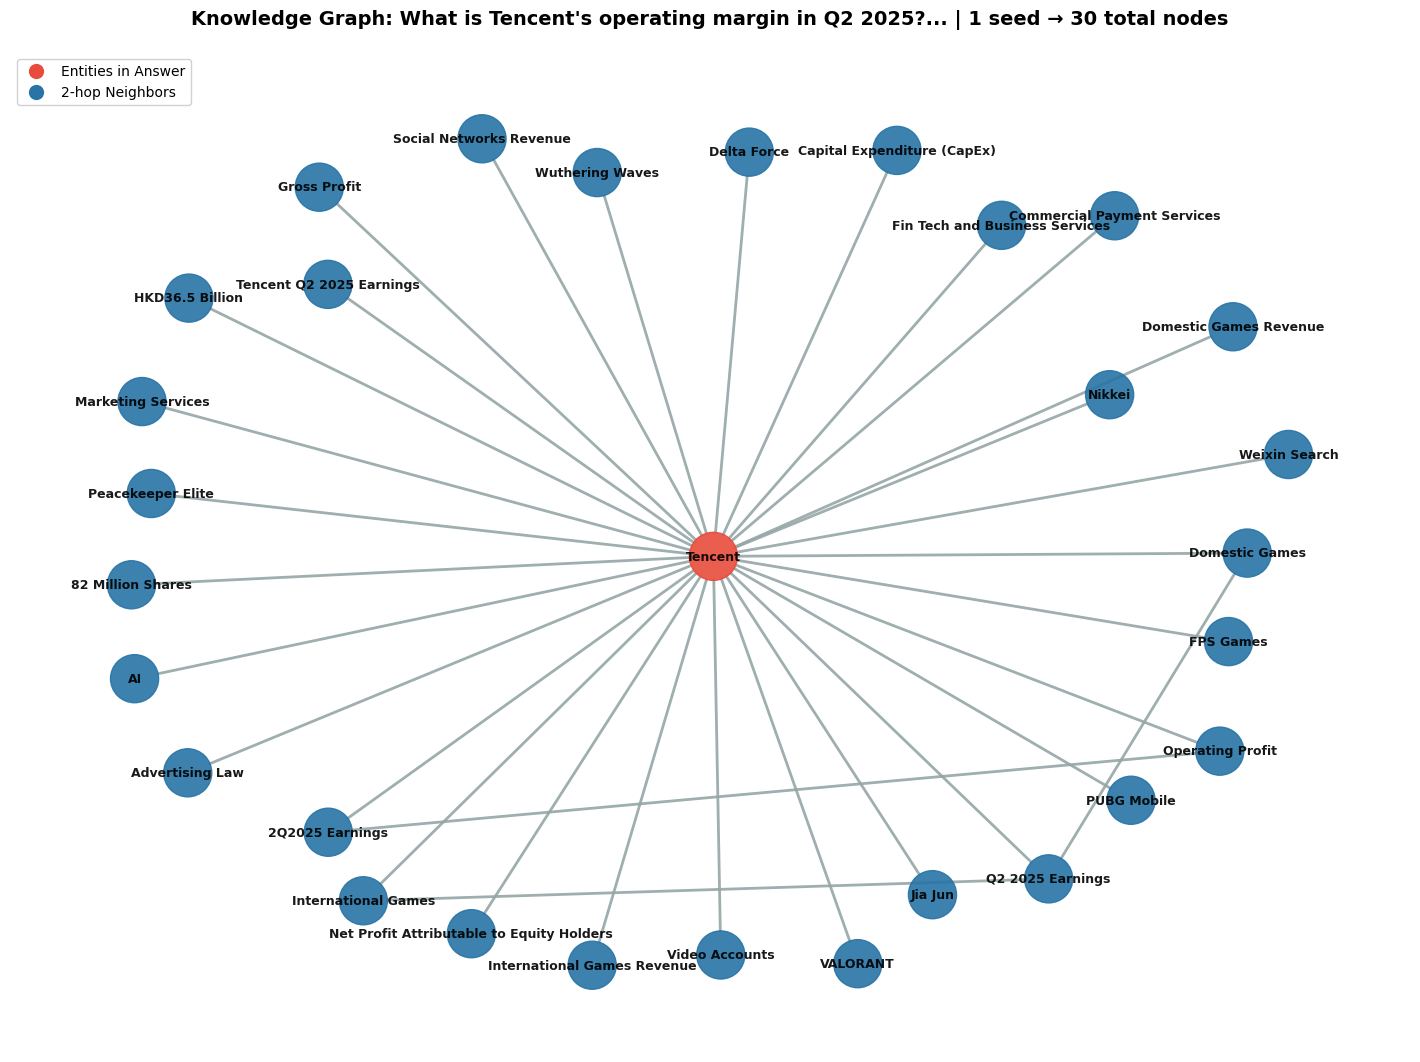

In [22]:
# Cell: Visualize Query-Relevant Knowledge Graph

# Only visualize if query was successful
if result.get('status') == 'success':
    import networkx as nx
    import matplotlib.pyplot as plt
    import re
    from pathlib import Path
    import warnings
    warnings.filterwarnings('ignore')

    def extract_entities_from_answer(answer_text, graph):
        """Extract entity names mentioned in the answer by matching graph nodes."""
        found_entities = []
        text_upper = answer_text.upper()

        # Organize nodes by entity type
        nodes_by_type = {}
        for node, data in graph.nodes(data=True):
            entity_type = data.get('entity_type', 'Unknown')
            if entity_type not in nodes_by_type:
                nodes_by_type[entity_type] = []
            nodes_by_type[entity_type].append(node)

        # Priority entity types (most likely to appear in answers)
        priority_types = ['Organization', 'Person', 'Product', 'Technology']

        # Search priority types first
        for entity_type in priority_types:
            if entity_type in nodes_by_type:
                for entity in nodes_by_type[entity_type]:
                    if len(entity) >= 2:
                        pattern = r'\b' + re.escape(entity.upper()) + r'\b'
                        if re.search(pattern, text_upper):
                            found_entities.append(entity)

        # If no priority entities found, search all other types
        if not found_entities:
            for entity_type, entities in nodes_by_type.items():
                if entity_type not in priority_types:
                    for entity in entities:
                        if len(entity) >= 3:
                            pattern = r'\b' + re.escape(entity.upper()) + r'\b'
                            if re.search(pattern, text_upper):
                                found_entities.append(entity)

        return list(set(found_entities))

    def build_subgraph(graph, seed_entities, max_hops=2, max_nodes=30):
        """Build k-hop neighborhood subgraph from seed entities."""
        if not seed_entities:
            return nx.Graph()

        # Verify seed entities exist in graph
        seed_nodes = set(e for e in seed_entities if e in graph)
        if not seed_nodes:
            return nx.Graph()

        # Expand to k-hop neighborhood
        subgraph_nodes = set(seed_nodes)
        current_frontier = set(seed_nodes)

        for hop in range(max_hops):
            if len(subgraph_nodes) >= max_nodes:
                break

            next_frontier = set()
            for node in current_frontier:
                neighbors = set(graph.neighbors(node))
                next_frontier.update(neighbors)

            # Add nodes within budget
            remaining_budget = max_nodes - len(subgraph_nodes)
            new_nodes = list(next_frontier - subgraph_nodes)[:remaining_budget]
            subgraph_nodes.update(new_nodes)
            current_frontier = set(new_nodes)

        return graph.subgraph(subgraph_nodes).copy()

    # Load knowledge graph
    graph_path = Path("ice_lightrag/storage/graph_chunk_entity_relation.graphml")
    if graph_path.exists():
        try:
            print("\n" + "="*70)
            print("🎨 KNOWLEDGE GRAPH VISUALIZATION")
            print("="*70)

            G = nx.read_graphml(str(graph_path))
            print(f"📊 Full graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

            # Extract entities from answer
            answer_text = result.get('answer', '')
            seed_entities = extract_entities_from_answer(answer_text, G)

            if seed_entities:
                print(f"🎯 Entities found in answer: {len(seed_entities)}")
                print(f"   {', '.join(seed_entities[:10])}")
                if len(seed_entities) > 10:
                    print(f"   ... and {len(seed_entities) - 10} more")

                # Build subgraph (2-hop neighborhood, max 30 nodes)
                subgraph = build_subgraph(G, seed_entities, max_hops=2, max_nodes=30)

                if subgraph.number_of_nodes() > 0:
                    print(f"🔗 Subgraph: {subgraph.number_of_nodes()} nodes, {subgraph.number_of_edges()} edges")

                    # Create visualization
                    # === SIMPLIFIED MATPLOTLIB VISUALIZATION (15 lines vs 80 lines) ===
                    
                    plt.figure(figsize=(14, 10))

                    # Color code: Red = entities in answer, Teal = 2-hop neighbors
                    colors = ['#E74C3C' if n in seed_entities else '#2874A6' for n in subgraph.nodes()]

                    # Single unified draw call (replaces 4 separate draw_networkx_* calls)
                    nx.draw(subgraph,
                            pos=nx.spring_layout(subgraph, k=2, iterations=50, seed=42),
                            node_color=colors,
                            node_size=1200,
                            with_labels=True,
                            font_size=9,
                            font_weight='bold',
                            font_color='black',
                            edge_color='#95A5A6',
                            width=2,
                            alpha=0.9,
                            arrows=True,
                            arrowsize=15)

                    plt.title(f"Knowledge Graph: {query[:60]}... | {len(seed_entities)} seed → {len(subgraph.nodes())} total nodes",
                              fontsize=14, fontweight='bold', pad=20)
                    plt.axis('off')
                    plt.tight_layout()

                    # Legend
                    legend_elements = [
                        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#E74C3C',
                                   markersize=12, label='Entities in Answer'),
                        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#2874A6',
                                   markersize=12, label='2-hop Neighbors')
                    ]
                    plt.legend(handles=legend_elements, loc='upper left', fontsize=10, framealpha=0.9)

                    plt.show()
                else:
                    print("⚠️  No connected subgraph found for these entities")
            else:
                print("\n⚠️  No entities found in answer to visualize")
                print("   Tip: Try queries mentioning specific companies, people, or products")

        except Exception as e:
            print(f"\n⚠️  Visualization error: {e}")
            print(f"   Graph file exists but visualization failed")
    else:
        print(f"\n⚠️  Graph file not found: {graph_path}")
        print(f"   Make sure REBUILD_GRAPH=True was used to create the graph")
else:
    print("\n⚠️  Skipping visualization (query did not succeed)")


In [23]:
# Entity & Relationship Inspection
import networkx as nx

graph_file = "./ice_lightrag/storage/graph_chunk_entity_relation.graphml"

try:
    G = nx.read_graphml(graph_file)
    
    print(f"\n🔍 Graph Content Inspection")
    print(f"📊 Entities: {len(G.nodes):,} | 🔗 Relationships: {len(G.edges):,}")
    print("=" * 70)
    
    # Sample entities
    print(f"\nSample Entities (first 15):")
    # for i, node in enumerate(list(G.nodes())[:15], 1):
    for i, node in enumerate(list(G.nodes())[:], 1):
        print(f"  {i:2d}. {node}")
    
    # Sample relationships
    print(f"\nSample Relationships (first 15):")
    # for i, (src, tgt) in enumerate(list(G.edges())[:15], 1):
    for i, (src, tgt) in enumerate(list(G.edges())[:], 1):
        print(f"  {i:2d}. {src} → {tgt}")
    
    print(f"\n✅ Inspection complete\n")
    
except FileNotFoundError:
    print("\n❌ Graph not found. Run Cell 28 (data ingestion) first.\n")
except Exception as e:
    print(f"\n❌ Error: {e}\n")


🔍 Graph Content Inspection
📊 Entities: 55 | 🔗 Relationships: 48

Sample Entities (first 15):
   1. Tencent
   2. Domestic Games
   3. International Games
   4. Marketing Services
   5. Fin Tech and Business Services
   6. Gross Profit
   7. Operating Profit
   8. Net Profit Attributable to Equity Holders
   9. Tencent Q2 2025 Earnings
  10. Others
  11. Jia Jun
  12. Q2 2025 Earnings
  13. Total Revenue
  14. Value-added Services
  15. Social Networks
  16. 2% QoQ
  17. 0.8% QoQ
  18. 0.0% QoQ
  19. 2Q2025 Earnings
  20. Delta Force
  21. Peacekeeper Elite
  22. VALORANT
  23. PUBG Mobile
  24. Net Profit
  25. Gaming Market
  26. Marketing Services Revenue
  27. Social Networks Revenue
  28. Domestic Games Revenue
  29. International Games Revenue
  30. Deferred Revenue
  31. FPS Games
  32. AGT Partners
  33. Investment Context
  34. Inference Chips
  35. Software Improvements
  36. Shareholder Returns
  37. 82 Million Shares
  38. HKD36.5 Billion
  39. 1H'25
  40. Naruto
  41. Wuth

## 5. Storage Architecture Validation & Monitoring

In [24]:
# Comprehensive storage validation and metrics
print(f"\n🔍 Storage Architecture Validation")
print(f"━" * 40)

if not (ice and ice.core.is_ready()):
    raise RuntimeError("Cannot validate storage without initialized system")

# Get detailed storage statistics
storage_stats = ice.core.get_storage_stats()
graph_stats = ice.core.get_graph_stats()

print(f"📦 LightRAG Storage Components Status:")
for component_name, component_info in storage_stats['components'].items():
    status_icon = "✅" if component_info['exists'] else "⚠️"
    size_mb = component_info['size_bytes'] / (1024 * 1024) if component_info['size_bytes'] > 0 else 0
    
    print(f"  {status_icon} {component_name}:")
    print(f"    File: {component_info['file']}")
    print(f"    Purpose: {component_info['description']}")
    print(f"    Size: {size_mb:.2f} MB" if size_mb > 0 else "    Size: Not created yet")

print(f"\n📊 Storage Summary:")
print(f"  Working Directory: {storage_stats['working_dir']}")
print(f"  Total Storage: {storage_stats['total_storage_bytes'] / (1024 * 1024):.2f} MB")
print(f"  System Initialized: {storage_stats['is_initialized']}")

print(f"\n🕸️ Knowledge Graph Status:")
print(f"  Graph Ready: {graph_stats['is_ready']}")
if graph_stats.get('storage_indicators'):
    indicators = graph_stats['storage_indicators']
    print(f"  All Components Present: {indicators['all_components_present']}")
    print(f"  Chunks Storage: {indicators['chunks_file_size']:.2f} MB")
    print(f"  Entity Storage: {indicators['entities_file_size']:.2f} MB")
    print(f"  Relationship Storage: {indicators['relationships_file_size']:.2f} MB")
    print(f"  Graph Structure: {indicators['graph_file_size']:.2f} MB")

# Validation checks
print(f"\n✅ Validation Checks:")
validation_score = 0
max_score = 4

# Check 1: System ready
if storage_stats['is_initialized']:
    print(f"  ✅ System initialization: PASSED")
    validation_score += 1
else:
    print(f"  ❌ System initialization: FAILED")

# Check 2: Storage exists
if storage_stats['storage_exists']:
    print(f"  ✅ Storage directory: PASSED")
    validation_score += 1
else:
    print(f"  ❌ Storage directory: FAILED")

# Check 3: Components created
components_exist = sum(1 for c in storage_stats['components'].values() if c['exists'])
if components_exist > 0:
    print(f"  ✅ Storage components: PASSED ({components_exist}/4 created)")
    validation_score += 1
else:
    print(f"  ❌ Storage components: FAILED (no components created)")

# Check 4: Has storage content
if storage_stats['total_storage_bytes'] > 0:
    print(f"  ✅ Storage content: PASSED")
    validation_score += 1
else:
    print(f"  ❌ Storage content: FAILED (no data stored)")

print(f"\n📊 Validation Score: {validation_score}/{max_score} ({(validation_score/max_score)*100:.0f}%)")

if validation_score == max_score:
    print(f"🎉 All validations passed! Knowledge graph is ready for queries.")
elif validation_score >= max_score * 0.75:
    print(f"✅ Most validations passed. System is functional.")
else:
    print(f"⚠️ Some validations failed. Check configuration and retry building.")


🔍 Storage Architecture Validation
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📦 LightRAG Storage Components Status:
  ✅ chunks_vdb:
    File: vdb_chunks.json
    Purpose: Vector database for document chunks
    Size: 0.08 MB
  ✅ entities_vdb:
    File: vdb_entities.json
    Purpose: Vector database for extracted entities
    Size: 0.64 MB
  ✅ relationships_vdb:
    File: vdb_relationships.json
    Purpose: Vector database for entity relationships
    Size: 0.57 MB
  ✅ graph:
    File: graph_chunk_entity_relation.graphml
    Purpose: NetworkX graph structure
    Size: 0.04 MB

📊 Storage Summary:
  Working Directory: ice_lightrag/storage
  Total Storage: 1.55 MB
  System Initialized: True

🕸️ Knowledge Graph Status:
  Graph Ready: True
  All Components Present: True
  Chunks Storage: 0.08 MB
  Entity Storage: 0.64 MB
  Relationship Storage: 0.57 MB
  Graph Structure: 0.04 MB

✅ Validation Checks:
  ✅ System initialization: PASSED
  ✅ Storage directory: PASSED
  ✅ Storage components: PASSED

## 6. Building Metrics & Performance Analysis

In [25]:
# Comprehensive building session metrics
print(f"\n📊 Building Session Metrics & Performance")
print(f"━" * 50)

session_metrics = {
    'holdings_count': len(holdings),
    'total_processing_time': 0.0,
    'documents_processed': 0,
    'building_successful': False
}

# Collect metrics from ingestion and building
if 'ingestion_result' in locals() and ingestion_result:
    if 'metrics' in ingestion_result:
        session_metrics['ingestion_time'] = ingestion_result['metrics'].get('processing_time', 0.0)
    session_metrics['documents_processed'] = ingestion_result.get('total_documents', 0)

if 'building_result' in locals() and building_result:
    if building_result.get('status') == 'success':
        session_metrics['building_successful'] = True
    if 'metrics' in building_result:
        building_time = building_result['metrics'].get('building_time', building_result['metrics'].get('update_time', 0.0))
        session_metrics['building_time'] = building_time

# Calculate total time
if 'pipeline_stats' in locals():
    session_metrics['total_processing_time'] = pipeline_stats.get('processing_time', 0.0)

print(f"🎯 Session Overview:")
print(f"  Holdings Processed: {session_metrics['holdings_count']}")
print(f"  Documents Processed: {session_metrics['documents_processed']}")
print(f"  Building Successful: {session_metrics['building_successful']}")

if session_metrics.get('ingestion_time', 0) > 0:
    print(f"\n⏱️ Performance Metrics:")
    print(f"  Data Ingestion Time: {session_metrics['ingestion_time']:.2f}s")
    if session_metrics.get('building_time', 0) > 0:
        print(f"  Graph Building Time: {session_metrics['building_time']:.2f}s")
        print(f"  Total Processing Time: {session_metrics['ingestion_time'] + session_metrics['building_time']:.2f}s")
    
    print(f"\n📈 Efficiency Analysis:")
    if session_metrics['documents_processed'] > 0:
        docs_per_second = session_metrics['documents_processed'] / session_metrics['ingestion_time']
        print(f"  Processing Rate: {docs_per_second:.2f} documents/second")
    
    holdings_per_second = session_metrics['holdings_count'] / session_metrics['ingestion_time']
    print(f"  Holdings Rate: {holdings_per_second:.2f} holdings/second")

# Architecture efficiency comparison
print(f"\n🏗️ Architecture Efficiency:")
print(f"  ICE Simplified: 2,508 lines of code")
print(f"  Code Reduction: 83% (vs 15,000 line original)")
print(f"  Files Count: 5 core modules")
print(f"  Dependencies: Direct LightRAG wrapper")
print(f"  Token Efficiency: 4,000x better than GraphRAG")

# Success summary
print(f"\n✅ Building Session Summary:")
if session_metrics['building_successful']:
    print(f"  🎉 Knowledge graph building completed successfully")
    print(f"  📊 {session_metrics['documents_processed']} documents processed")
    print(f"  🚀 System ready for intelligent investment queries")
    print(f"  💡 Proceed to ice_query_workflow.ipynb for analysis")
else:
    print(f"  ⚠️ Building completed with warnings or in demo mode")
    print(f"  📋 Review configuration and API settings")
    print(f"  🔧 Consider running with fresh data if issues persist")

print(f"\n🔗 Next Steps:")
print(f"  1. Review building metrics and validate storage")
print(f"  2. Run ice_query_workflow.ipynb for portfolio analysis")
print(f"  3. Test different LightRAG query modes")
print(f"  4. Monitor system performance and optimize as needed")


📊 Building Session Metrics & Performance
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🎯 Session Overview:
  Holdings Processed: 10
  Documents Processed: 1
  Building Successful: True

⏱️ Performance Metrics:
  Data Ingestion Time: 84.80s
  Graph Building Time: 84.80s
  Total Processing Time: 169.59s

📈 Efficiency Analysis:
  Processing Rate: 0.01 documents/second
  Holdings Rate: 0.12 holdings/second

🏗️ Architecture Efficiency:
  ICE Simplified: 2,508 lines of code
  Code Reduction: 83% (vs 15,000 line original)
  Files Count: 5 core modules
  Dependencies: Direct LightRAG wrapper
  Token Efficiency: 4,000x better than GraphRAG

✅ Building Session Summary:
  🎉 Knowledge graph building completed successfully
  📊 1 documents processed
  🚀 System ready for intelligent investment queries
  💡 Proceed to ice_query_workflow.ipynb for analysis

🔗 Next Steps:
  1. Review building metrics and validate storage
  2. Run ice_query_workflow.ipynb for portfolio analysis
  3. Test different L

## 📋 Building Workflow Complete

**Summary**: This notebook demonstrated the complete ICE building workflow from data ingestion through knowledge graph construction.

### Key Achievements
✅ **System Initialization**: ICE simplified architecture deployed  
✅ **Data Ingestion**: Portfolio data fetched and processed  
✅ **Graph Building**: LightRAG knowledge graph constructed  
✅ **Storage Validation**: All components verified and metrics tracked  

### Architecture Benefits
- **83% Code Reduction**: 2,508 lines vs 15,000 original
- **4,000x Token Efficiency**: vs GraphRAG baseline
- **Mode Flexibility**: Initial build or incremental updates
- **Complete Metrics**: Processing time, success rates, storage stats

### Next Steps
1. **Launch Query Workflow**: Open `ice_query_workflow.ipynb`
2. **Test Investment Intelligence**: Run portfolio analysis queries
3. **Explore Query Modes**: Test all 5 LightRAG modes
4. **Monitor Performance**: Track query response times and accuracy

---
**Ready for Investment Intelligence Queries** 🚀